In [2]:
# Look at one period problem, alpha=alphal or alphah forever
# Money and cc, only buyers
# For c to be accepted in stst, need gammac<alpha*gammam-(1-alpha)(1-B)
# Set U(X)=X; u(q)=((q+b)**(1-eta)-b**eta)/(1-eta); c(q)=q 
# So u'=(q+b)**-eta; c'=1; z(q)=(1-theta)u(q)+theta*c(q); z'=(1-theta)*(q+b)**(-eta)+theta;
# l=theta*(u'(q)-c'(q))/z'(q)
# l=theta*((q+b)**(-eta)-1)/((1-theta)*(q+b)**(-eta)+theta)=theta*(1-(q-b)**eta)/(1-theta*(1-(q+b)**eta))
import math
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from IPython.core.debugger import set_trace
file = r'C:\Users\spspi\Dropbox\Documents\Cryptocurrency Project\Simulations' #Save simulation graphs here
b = .00001 # This is part of utility function, makes it steep around 0
B = .95 # Discount rate beta
lam = .75 # Meeting rate lambda
theta = .75 # Buyer bargaining power
eta = .75 # Buyer risk aversion
gammam = 0.02 # Money inflation rate
gammac = 0 # CC inflation rate
qstar = 1 - b # Value at which u'=c'

# First, need to find steady state prices. Assume enite wealth always spent.
# phi/(phi'B)-1=(1+gammam)/B=i_m=lamb*l(phi'm'+psi'c')+lamm*l(phi'm')=lamb*l(qb)+lamm*l(gm)
# psi/(psi'B)-1=(1+gammac)/B=i_c=lamb*l(phi'm'+psi'c')=lamm*l(qb)

# Create a function that finds tomorrow's q's in stst
def ststq(alpha, Mp, Cp, gammam = gammam, gammac=gammac, lam=lam, theta=theta, eta=eta):
    lamb = lam * alpha # Chance of both type meeting
    lamm = lam * (1 - alpha) # Chance of money type meeting
    if alpha > (gammac + 1 - B) / (gammam + 1 - B): # If cc is valued, can solve these equations for q, because m=M in st st
        # Both type meetings
        qb = np.minimum(np.maximum((np.maximum((theta * B * lamb - (1 - theta) * (1 + gammac - B)) / (theta*
                                             (1 + gammac - B + B * lamb)), 0)) ** (1 / eta) - b, 0), qstar)
        # Money type meetings
        qm=np.minimum(np.maximum((np.maximum((theta * B * lamm - (1 - theta) * (gammam - gammac))
                                          / (theta * (gammam - gammac + B * lamm)), 0)) ** (1 / eta) - b, 0), qstar)
        return qb, qm
    else: # If cc not valued,then get same q in both meetings
        qm = np.minimum(np.maximum((np.maximum((theta * B * lam - (1 - theta) * (1 + gammam - B))/
                                               (theta * (1 + gammam - B + B * lam)), 0))**(1 / eta) - b, 0), qstar)
        return qm, qm

# Create a function that finds tomorrow's price in stst
def ststprices(alpha, Mp, Cp, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta):
    qb, qm=ststq(alpha, Mp, Cp, gammam, gammac, lam, theta, eta) # Find qb and qm from above
    if eta != 1: # If not ln utility
        # Tomorrow's price of money
        phip = (theta * qm + (1 - theta) * ((qm + b) ** (1 - eta) - b ** (1 - eta)) / (1 - eta)) / Mp
        # Tomorrow's price of cc
        psip = (theta * (qb - qm) + (1 - theta) * ((qb + b) ** (1 - eta) - (qm + b) ** (1 - eta)) / (1 - eta)) / Cp
    else: # if ln utility
        # Tomorrow's price of money
        phip = (theta * qm + (1 - theta) * (np.log(qm + b) - np.log(b))) / Mp
        # Tomorrow's price of cc
        psip = (theta * (qb - qm) + (1 - theta) * (np.log(qb + b) - np.log(qm + b))) / Cp
    return phip, psip    

# Create an explicit utility function so q is never negative
def u(q, eta=eta):
    q = np.array(q)
    if q < 0: # Don't want negative consumption
        return -1e6
    elif eta != 1: # If not ln utility
        return ((q + b) ** (1 - eta) - b ** (1 - eta)) / (1 - eta)
    else: # if ln utility
        return np.log(qstar + b) - np.log(b)
    
def du(q, eta=eta):
    q = np.array(q)
    if q < 0: # If negative, no slope
        return 0
    else: 
        return (q + b) ** (-eta)
    
# Create a function that outputs z(q(w))=w for a given wealth w and q (solve by giving a w, set this equal to 0, and solve for q)
def wminz(q, w, eta=eta):
    return w - theta * q - (1 - theta) * u(q, eta)

# Create a function to take the derivative of z
def dz(q):
    q = np.array(q)
    if q < 0:
        return 0
    if q >= qstar:
        return 0
    else:
        return theta + (1 - theta) * (q + b) ** (-eta)
    
# Create a function to solve for q given w, this time with bisect (sensitive to first guess)
def qwealth(w, eta=eta):
    w = np.array(w)
    if w > 0:
        q = optimize.brentq(wminz, -1e25, 1e25, args=(w, eta))
        if q <= 0:
            return 0
        if q >= qstar:
            return qstar
        else:
            return q
    else:
        return 0
    
# Create a function that outputs liquidity for a given q
def liquidityq(q):
    if q >= qstar:
        return 0 
    elif q < 0:
        return 0
    else:
        return (theta * (1 - (q + b) ** eta)) / (1 - theta * (1 - (q + b) ** eta))

# Create a function to take the derivative of liquidityq
def dliqq(q):
    if q < 0:
        return 0
    if q >= qstar:
        return 0
    return - theta * eta * (q + b) ** (eta - 1) / (1 - theta * (1 - (q + b) ** eta)) ** 2

# Create a function to solve for q given w and output liquidity 
def liquidity(w):
    if w < 0:
        return 0
    return liquidityq(qwealth(w))

# Create a function to take the derivative of liquidity
def dliq(w):
    if w < 0:
        return 0
    q = qwealth(w)
    if q < 0:
        return 0
    if q >= qstar:
        return 0
    return dliqq(q) / dz(q)
    
# Create a function that outputs total surplus given wealth
def surplus(w):
    if w <= 0:
        return 0
    else:
        return u(qwealth(w)) - qwealth(w)
    
# Create a function that outputs value of continuing in stst given an alpha
def ststW(alpha, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta):
    Mp, Cp = 1, 1 # Does not matter what these are, so choose these for simplicity
    lamb = lam * alpha # Chance of both type meeting
    lamm = lam * (1 - alpha) # Chance of money type meeting
    qb, qm = ststq(alpha, Mp, Cp, gammam, gammac, lam, theta, eta) # Find qb and qm from above
    phip, psip = ststprices(alpha, Mp, Cp, gammam, gammac, lam, theta, eta) # Find prices from above
    # Can solve \bar{W}(0,0) to get              
    return - Mp * phip - Cp * psip + B / (1 - B) * theta * (lamb * (u(qb) - qb) + lamm * (u(qm) - qm)) 

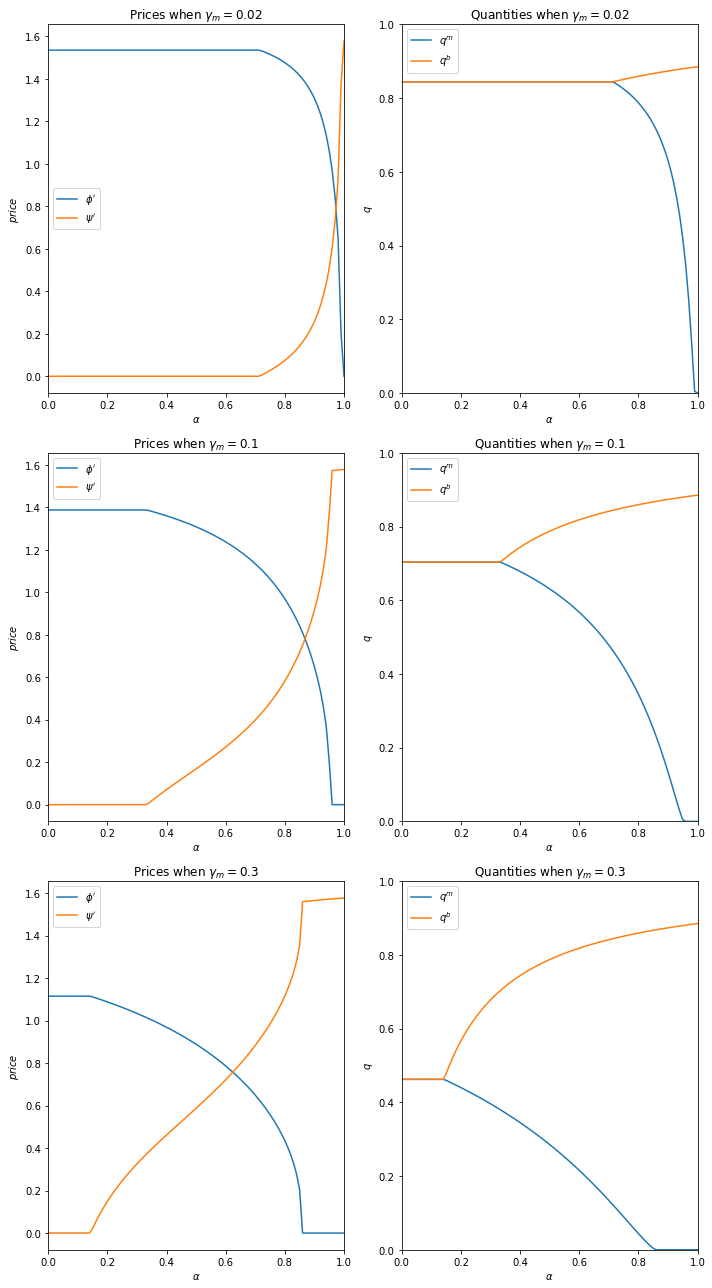

In [3]:
# How does stst look when we change parameters?
# First change alpha, see how this looks for different gammam
Mp=1
Cp=1
top=1
alphagrid=np.linspace(0,top,101)
gammamgrid=[.02,.1,.3]
#gammamgrid=[.02,.1] # If I only want to graph gammam=.02 and gammam=.1
fig,axes=plt.subplots(len(gammamgrid),2,figsize=(10,18))
for j,gammam in enumerate(gammamgrid):
    phipgrid,psipgrid,qbgrid,qmgrid,qbqgrid,qmqgrid=[],[],[],[],[],[]
    for alpha in alphagrid:
            phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam)
            phipgrid.append(phiptemp), psipgrid.append(psiptemp)
            qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam)
            qbgrid.append(qbtemp),qmgrid.append(qmtemp) 
            qbqgrid.append(qwealth(Mp*phiptemp+Cp*psiptemp)),qmqgrid.append(qwealth(Mp*phiptemp))
    
    
    axes[j,0].plot(alphagrid,phipgrid,label="$\phi'$")
    axes[j,0].plot(alphagrid,psipgrid,label="$\psi'$")
    axes[j,0].legend()
    axes[j,0].set_title(f"Prices when $\gamma_m={gammam}$")
    axes[j,0].set_xlabel(r"$\alpha$")
    axes[j,0].set_xlim(0,top)
    axes[j,0].set_ylabel("$price$")
    axes[j,1].plot(alphagrid,qmgrid,label="$q^m$")
    axes[j,1].plot(alphagrid,qbgrid,label="$q^b$")
    axes[j,1].legend()
    axes[j,1].set_title(f"Quantities when $\gamma_m={gammam}$")
    axes[j,1].set_xlabel(r"$\alpha$")
    axes[j,1].set_xlim(0,top)
    axes[j,1].set_ylabel("$q$")   
    axes[j,1].set_ylim(0,1)
#     axes[j,2].plot(alphagrid,np.asarray(qmgrid)-np.asarray(qmqgrid),label="$q^m-q_2^m$")
#     axes[j,2].plot(alphagrid,np.asarray(qbgrid)-np.asarray(qbqgrid),label="$q^b-q_2^b$")
#     axes[j,2].legend()
#     axes[j,2].set_xlabel(r"$\alpha$")
#     axes[j,2].set_xlim(0,top)
#     axes[j,2].set_ylabel("$q-q_2$")   

plt.tight_layout()
#plt.savefig(file+r'\steadystate\ststalphgamm.pdf') #If I want to save figures
# plt.savefig(file+r'\steadystate\ststalphgamm2.pdf') #If I want to save figures (used with only gammmam=.02 and .1)
plt.show()


C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


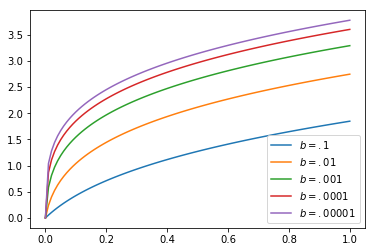

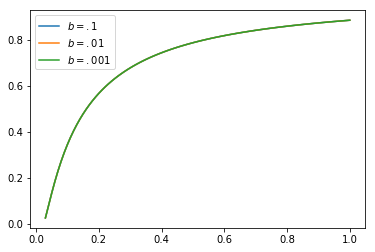

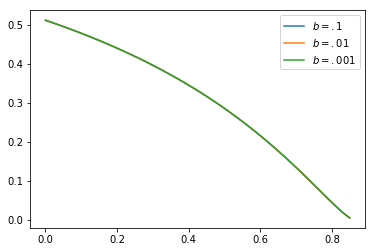

In [4]:
# What does u() look like for various b? How high of alpha is qm/qb solved for various b?
bgrid,qgrid=np.meshgrid([.1,.01,.001,.0001,.00001],np.linspace(0,qstar,101))
bgrid2,alphagrid=np.meshgrid([.1,.01,.001,.0001,.00001],np.linspace(0,1,101))

ugrid=((qgrid+bgrid)**(1-eta)-bgrid**(1-eta))/(1-eta)
lamb=lam*alphagrid # Chance of both type meeting
lamm=lam*(1-alphagrid) # Chance of money type meeting
# Both type meetings
qbgrid=((theta*B*lamb-(1-theta)*(1+gammac-B))/theta/(1+gammac-B+B*lamb))**(1/eta)-b
# Money type meetings
qmgrid=((theta*B*lamm-(1-theta)*(gammam-gammac))/theta/(gammam-gammac+B*lamm))**(1/eta)-b
    
fig,ax=plt.subplots()
ax.plot(qgrid[:,0],ugrid[:,0],label=r"$b=.1$")
ax.plot(qgrid[:,1],ugrid[:,1],label=r"$b=.01$")
ax.plot(qgrid[:,2],ugrid[:,2],label=r"$b=.001$")
ax.plot(qgrid[:,3],ugrid[:,3],label=r"$b=.0001$")
ax.plot(qgrid[:,4],ugrid[:,4],label=r"$b=.00001$")
ax.legend()
plt.show()


fig,ax=plt.subplots()
ax.plot(alphagrid[:,0],qbgrid[:,0],label=r"$b=.1$")
ax.plot(alphagrid[:,1],qbgrid[:,1],label=r"$b=.01$")
ax.plot(alphagrid[:,2],qbgrid[:,2],label=r"$b=.001$")
ax.legend()
plt.show()

fig,ax=plt.subplots()
ax.plot(alphagrid[:,0],qmgrid[:,0],label=r"$b=.1$")
ax.plot(alphagrid[:,1],qmgrid[:,1],label=r"$b=.01$")
ax.plot(alphagrid[:,2],qmgrid[:,2],label=r"$b=.001$")
ax.legend()
plt.show()
plt.close()

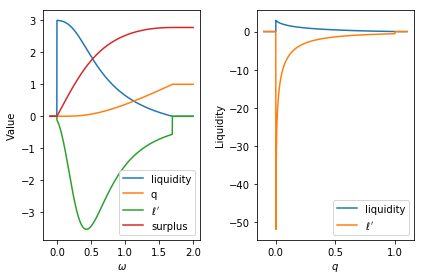

In [6]:
# Make sure liquidity, liquidityq, qwealth, surplus, dliq and dliqq are working
wealthgrid=np.linspace(-.1,2,1001)
qgrid=np.linspace(-.1,qstar+.1,1001)
l,lq,q,dl,dlq,s=[],[],[],[],[],[]

for wealth in wealthgrid:
    l.append(liquidity(wealth)),q.append(qwealth(wealth)),dl.append(dliq(wealth)),s.append(surplus(wealth))

for qi in qgrid:
    lq.append(liquidityq(qi)),dlq.append(dliqq(qi))

fig,axes=plt.subplots(1,2)
axes[0].plot(wealthgrid,l,label="liquidity")
axes[0].plot(wealthgrid,q,label="q")
axes[0].plot(wealthgrid,dl,label=r"$\ell'$")
axes[0].plot(wealthgrid,s,label=r"surplus")
axes[0].legend()
axes[0].set_xlabel(r"$\omega$")
axes[0].set_ylabel("Value")
axes[1].plot(qgrid,lq,label="liquidity")
axes[1].plot(qgrid,dlq,label=r"$\ell'$")
axes[1].legend()
axes[1].set_xlabel(r"$q$")
axes[1].set_ylabel("Liquidity")

plt.tight_layout()
plt.show()
plt.close()

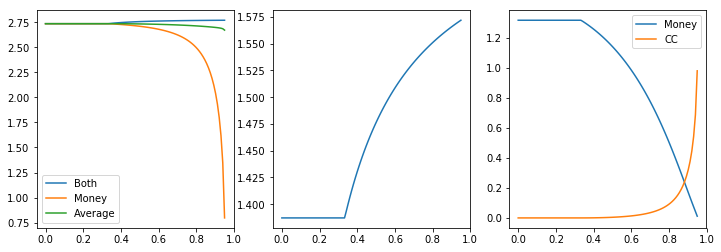

In [7]:
# How does surplus, total liquidity, and buyer's value of money/cc holdings change with alpha?
Mp=1
Cp=1
gammam=.1
top=.95
alphagrid=np.linspace(0,top,101)
im=(1+gammam)/B-1
ic=(1+gammac)/B-1
surplusb,surplusm,surplusav,tl,valuem,valuec=[],[],[],[],[],[]
#surplusb2,surplusm2,surplusav2=[],[],[] # How accurate is surplus function? 
#surplusbd,surplusmd=[],[] # How accurate is surplus function?

for alpha in alphagrid:
    qb,qm=ststq(alpha,Mp,Cp,gammam=gammam,eta=eta)
    phi,psi=ststprices(alpha,Mp,Cp,gammam=gammam,eta=eta)
    surplusb.append(u(qb,eta=eta)-qb),surplusm.append(u(qm,eta=eta)-qm)
    surplusav.append(alpha*(u(qb,eta=eta)-qb)+(1-alpha)*(u(qm,eta=eta)-qm))
    #surplusb2.append(surplus(phi*Mp+psi*Cp)),surplusm2.append(surplus(phi*Mp))
    #surplusav2.append(alpha*surplus(phi*Mp+psi*Cp)+(1-alpha)*surplus(phi*Mp))
    #surplusbd.append(u(qb,eta=eta)-qb-surplus(phi*Mp+psi*Cp)),surplusmd.append(u(qm,eta=eta)-qm-surplus(phi*Mp))
    tl.append(Mp*phi+Cp*psi)
    valuem.append(-im*phi*Mp+ \
                  lam*(alpha*theta*((u(qb,eta=eta)-qb)-surplus(psi*Cp))+(1-alpha)*theta*(u(qm,eta=eta)-qm)))
    valuec.append(-ic*psi*Cp+lam*alpha*theta*((u(qb,eta=eta)-qb)-(u(qm,eta=eta)-qm)))
    
fig,ax=plt.subplots(1,3,figsize=(12,4))
ax[0].plot(alphagrid,surplusb,label="Both")
ax[0].plot(alphagrid,surplusm,label="Money")
ax[0].plot(alphagrid,surplusav,label="Average")
ax[0].legend()
ax[1].plot(alphagrid,tl)
ax[2].plot(alphagrid,valuem,label="Money")
ax[2].plot(alphagrid,valuec,label="CC")
ax[2].legend()
#ax[2].set_ylim(bottom=0)
#ax[3].plot(alphagrid,surplusbd,label="Both")
#ax[3].plot(alphagrid,surplusmd,label="Money")
#ax[3].legend()
plt.show()
plt.close()

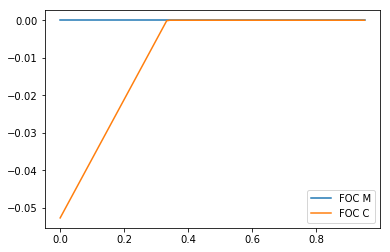

In [8]:
# Check focs
Mp=1
Cp=1
gammam=.1
top=.95
eta=2
im=(1+gammam)/B-1
ic=(1+gammac)/B-1
alphagrid=np.linspace(0,top,101)
focm,focc=[],[]

for alpha in alphagrid:
    lamb=lam*alpha
    lamm=lam*(1-alpha)
    qb,qm=ststq(alpha,Mp,Cp,gammam=gammam,eta=eta)
    focm.append(lamb*liquidityq(qb)+lamm*liquidityq(qm)-im),focc.append(lamb*liquidityq(qb)-ic)
    
fig,ax=plt.subplots()
ax.plot(alphagrid,focm,label="FOC M")
ax.plot(alphagrid,focc,label="FOC C")
ax.legend()
plt.show()
plt.close()    

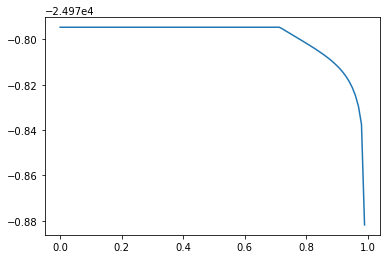

In [9]:
# What does ststW look like?
Mp=1
Cp=1
gammam=.02
alphagrid=np.linspace(0,.99,101)
Wgrid=[]

for alpha in alphagrid:
    Wgrid.append(ststW(alpha,gammam=gammam,eta=eta))

fig,ax=plt.subplots()
ax.plot(alphagrid,Wgrid)
plt.show()
plt.close()

In [6]:
# Just change gammam
alpha=.85
gammamgrid=np.linspace(.01,.51,101)
Mp=1
Cp=1
phip,psip,qb,qm=[],[],[],[]
for gammam in gammamgrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam)
    phip.append(phiptemp), psip.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam)
    qb.append(qbtemp),qm.append(qmtemp)
    
fig1,axes1=plt.subplots(1,2)
axes1[0].plot(gammamgrid,phip,label="$\phi'$")
axes1[0].plot(gammamgrid,psip,label="$\psi'$")
axes1[0].legend()
axes1[0].set_title(r"Prices given $\gamma_m$")
axes1[0].set_xlabel(r"$\gamma_m$")
axes1[0].set_xlim(0,.51)
axes1[0].set_ylabel("$price$")
axes1[1].plot(gammamgrid,qm,label="$q^m$")
axes1[1].plot(gammamgrid,qb,label="$q^b$")
axes1[1].legend()
axes1[1].set_title(r"Quantities given $\gamma_m$")
axes1[1].set_xlabel(r"$\gamma_m$")
axes1[1].set_xlim(0,.51)
axes1[1].set_ylabel("$q$")    
axes1[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststgammam.pdf')
plt.close()

In [7]:
# Just change gammac
alpha=.85
gammam=.31
gammacgrid=np.linspace(0,gammam,101)
Mp=1
Cp=1
phip,psip,qb,qm=[],[],[],[]
for gammac in gammacgrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam,gammac=gammac)
    phip.append(phiptemp), psip.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam,gammac=gammac)
    qb.append(qbtemp),qm.append(qmtemp)
    
fig1,axes1=plt.subplots(1,2)
axes1[0].plot(gammacgrid,phip,label="$\phi'$")
axes1[0].plot(gammacgrid,psip,label="$\psi'$")
axes1[0].legend()
axes1[0].set_title(r"Prices given $\gamma_c$")
axes1[0].set_xlabel(r"$\gamma_c$")
axes1[0].set_xlim(0,gammam)
axes1[0].set_ylabel("$price$")
axes1[1].plot(gammacgrid,qm,label="$q^m$")
axes1[1].plot(gammacgrid,qb,label="$q^b$")
axes1[1].legend()
axes1[1].set_title(r"Quantities given $\gamma_c$")
axes1[1].set_xlabel(r"$\gamma_c$")
axes1[1].set_xlim(0,gammam)
axes1[1].set_ylabel("$q$") 
axes1[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststgammac.pdf')
plt.close()

In [10]:
# Now for alpha=.6, gammam=.1, how does price and quantity change with lambda, eta and theta? Graph all separate for 
# presentations
gammam=.1
gammac=0
alpha=.6
alphal=(gammac+1-B)/(gammam+1-B) # The indifference condtion
Mp=1
Cp=1
thetagrid=np.linspace(0,1,101)
etagrid=np.linspace(0,1,101) 
lamgrid=np.linspace(0,1,101)
alphagrid=np.linspace(alphal,1,101) # For graphing
phiptheta,psiptheta,qbtheta,qmtheta=[],[],[],[]
phipeta,psipeta,qbeta,qmeta=[],[],[],[]
phiplam,psiplam,qblam,qmlam=[],[],[],[]
phipalpha,psipalpha,qbalpha,qmalpha=[],[],[],[]

for theta in thetagrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam,theta=theta)
    phiptheta.append(phiptemp), psiptheta.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam,theta=theta)
    qbtheta.append(qbtemp),qmtheta.append(qmtemp)

for eta in etagrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam,eta=eta)
    phipeta.append(phiptemp), psipeta.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam,eta=eta)
    qbeta.append(qbtemp),qmeta.append(qmtemp)
    
for lam in lamgrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam,lam=lam)
    phiplam.append(phiptemp), psiplam.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam,lam=lam)
    qblam.append(qbtemp),qmlam.append(qmtemp)
    
for alpha in alphagrid:
    phiptemp,psiptemp=ststprices(alpha,Mp,Cp,gammam)
    phipalpha.append(phiptemp), psipalpha.append(psiptemp)
    qbtemp,qmtemp=ststq(alpha,Mp,Cp,gammam)
    qbalpha.append(qbtemp),qmalpha.append(qmtemp)


fig1,axes1=plt.subplots(1,2)
axes1[0].plot(thetagrid,phiptheta,label="$\phi'$")
axes1[0].plot(thetagrid,psiptheta,label="$\psi'$")
axes1[0].legend()
axes1[0].set_title(r"Prices given $\theta$")
axes1[0].set_xlabel(r"$\theta$")
axes1[0].set_xlim(0,1)
axes1[0].set_ylabel("$Price$")
axes1[1].plot(thetagrid,qmtheta,label="$q^m$")
axes1[1].plot(thetagrid,qbtheta,label="$q^b$")
axes1[1].legend()
axes1[1].set_title(r"Quantities given $\theta$")
axes1[1].set_xlabel(r"$\theta$")
axes1[1].set_xlim(0,1)
axes1[1].set_ylabel("$q$")    
axes1[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststtheta.pdf')
plt.close()

fig2,axes2=plt.subplots(1,2)
axes2[0].plot(etagrid,phipeta,label="$\phi'$")
axes2[0].plot(etagrid,psipeta,label="$\psi'$")
axes2[0].legend()
axes2[0].set_title(r"Prices given $\eta$")
axes2[0].set_xlabel(r"$\eta$")
axes2[0].set_xlim(0,1)
axes2[0].set_ylabel("$Price$")
axes2[1].plot(etagrid,qmeta,label="$q^m$")
axes2[1].plot(etagrid,qbeta,label="$q^b$")
axes2[1].legend()
axes2[1].set_title(r"Quantities given $\eta$")
axes2[1].set_xlabel(r"$\eta$")
axes2[1].set_xlim(0,1)
axes2[1].set_ylabel("$q$")    
axes2[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststeta.pdf')
plt.close()

fig3,axes3=plt.subplots(1,2)
axes3[0].plot(lamgrid,phiplam,label="$\phi'$")
axes3[0].plot(lamgrid,psiplam,label="$\psi'$")
axes3[0].legend()
axes3[0].set_title(r"Prices given $\lambda$")
axes3[0].set_xlabel(r"$\lambda$")
axes3[0].set_xlim(0,1)
axes3[0].set_ylabel("$Price$")
axes3[1].plot(lamgrid,qmlam,label="$q^m$")
axes3[1].plot(lamgrid,qblam,label="$q^b$")
axes3[1].legend()
axes3[1].set_title(r"Quantities given $\lambda$")
axes3[1].set_xlabel(r"$\lambda$")
axes3[1].set_xlim(0,1)
axes3[1].set_ylabel("$q$")    
axes3[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststlambda.pdf')
plt.close()

fig4,axes4=plt.subplots(1,2)
axes4[0].plot(alphagrid,phipalpha,label="$\phi'$")
axes4[0].plot(alphagrid,psipalpha,label="$\psi'$")
axes4[0].legend()
axes4[0].set_title(r"Prices given $\alpha$")
axes4[0].set_xlabel(r"$\alpha$")
axes4[0].set_xlim(alphal,1)
axes4[0].set_ylabel("$Price$")
axes4[1].plot(alphagrid,qmalpha,label="$q^m$")
axes4[1].plot(alphagrid,qbalpha,label="$q^b$")
axes4[1].legend()
axes4[1].set_title(r"Quantities given $\alpha$")
axes4[1].set_xlabel(r"$\alpha$")
axes4[1].set_xlim(alphal,1)
axes4[1].set_ylabel("$q$")    
axes4[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\steadystate\ststalpha.pdf')
plt.close()

C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


In [27]:
# T={0,1}, mu=1 (no hodlers), so m=Mp/1 and c=Cp/1
gammam=.02
pi=.5 # Probability alpha=alpha0
M=1
C=1
Mp=M*(1+gammam) # tomorrow's money supply
Cp=C*(1+gammac) # tomorrow's cc supply

alpha0=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alpha1=(alpha0+1)/2# Don't want it to be 1, or money is not valued
lamb0,lamm0=lam*alpha0,lam*(1-alpha0) # Meeting proabilities in low state
lamb1,lamm1=lam*alpha1,lam*(1-alpha1) # Meeting proabilities in high state

phi0s,psi0s=ststprices(alpha0,Mp,Cp,gammam=gammam) # prices in low stst
phi1s,psi1s=ststprices(alpha1,Mp,Cp,gammam=gammam) # prices in high stst
phi0=(B*pi*phi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+lamm0*liquidity(phi0s*Mp)+1)+ 
     B*(1-pi)*phi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+lamm1*liquidity(phi1s*Mp)+1))
psi0=B*pi*psi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+1)+B*(1-pi)*psi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+1)

print(phi0,psi0)

1.21815520994 0.117646818083


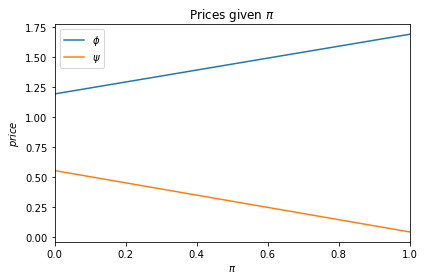

In [10]:
# How do prices and quantities change with pi?
# T={0,1}, mu=1 (no hodlers), so m=Mp/1 and c=Cp/1
gammam=.02
M=1
C=1
Mp=M*(1+gammam) # tomorrow's money supply
Cp=C*(1+gammac) # tomorrow's cc supply

alpha0=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alpha1=.95 # Don't want it to be 1, or money is not valued
lamb0,lamm0=lam*alpha0,lam*(1-alpha0) # Meeting proabilities in low state
lamb1,lamm1=lam*alpha1,lam*(1-alpha1) # Meeting proabilities in high state

phi0s,psi0s=ststprices(alpha0,Mp,Cp,gammam=gammam) # prices in low stst
phi1s,psi1s=ststprices(alpha1,Mp,Cp,gammam=gammam) # prices in high stst
pigrid=np.linspace(0,1,101)
phigrid,psigrid=[],[]

for pi in pigrid:
    phi0=B*pi*phi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+lamm0*liquidity(phi0s*Mp)+1)+ \
     B*(1-pi)*phi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+lamm1*liquidity(phi1s*Mp)+1)
    psi0=B*pi*psi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+1)+B*(1-pi)*psi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+1)
    phigrid.append(phi0),psigrid.append(psi0)
    
fig,ax=plt.subplots()
ax.plot(pigrid,phigrid,label="$\phi$")
ax.plot(pigrid,psigrid,label="$\psi$")
ax.legend()
ax.set_title(r"Prices given $\pi$")
ax.set_xlabel(r"$\pi$")
ax.set_xlim(0,1)
ax.set_ylabel("$price$")
#ax.set_ylim(0,3)

plt.tight_layout()
plt.show()
plt.close()

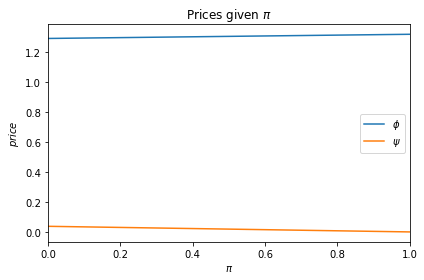

In [12]:
# Can we get a crash with just buyers? Have alphal make cc not valued, alphah it is, can there be positive prices today?
gammam=.02
M=1
C=1
Mp=M*(1+gammam) # tomorrow's money supply
Cp=C*(1+gammac) # tomorrow's cc supply

alpha0=(gammac+1-B)/(gammam+1-B)-.05 # Slightly below indifference condition
alpha1=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
lamb0,lamm0=lam*alpha0,lam*(1-alpha0) # Meeting proabilities in low state
lamb1,lamm1=lam*alpha1,lam*(1-alpha1) # Meeting proabilities in high state

phi0s,psi0s=ststprices(alpha0,Mp,Cp,gammam=gammam) # prices in low stst
phi1s,psi1s=ststprices(alpha1,Mp,Cp,gammam=gammam) # prices in high stst
pigrid=np.linspace(0,1,101)
phigrid,psigrid=[],[]

for pi in pigrid:
    phi0=B*pi*phi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+lamm0*liquidity(phi0s*Mp)+1)+ \
     B*(1-pi)*phi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+lamm1*liquidity(phi1s*Mp)+1)
    psi0=B*pi*psi0s*(lamb0*liquidity(phi0s*Mp+psi0s*Cp)+1)+B*(1-pi)*psi1s*(lamb1*liquidity(phi1s*Mp+psi1s*Cp)+1)
    phigrid.append(phi0),psigrid.append(psi0)
    
fig,ax=plt.subplots()
ax.plot(pigrid,phigrid,label="$\phi$")
ax.plot(pigrid,psigrid,label="$\psi$")
ax.legend()
ax.set_title(r"Prices given $\pi$")
ax.set_xlabel(r"$\pi$")
ax.set_xlim(0,1)
ax.set_ylabel("$price$")
#ax.set_ylim(0,3)

plt.tight_layout()
plt.show()

In [124]:
# Create periodprices to find prices outside of steady state
# Run first cell before this one.
# T={0,1}, 0<mu<1 (both buyers and hodlers), so mh=(Mp-mu*m)/(1-mu) and ch=(Cp-mu*c)/(1-mu)
# Two cases, 1. hodlers hold all cc, 2. both hold some cc
# To see if in case 1, solve with c=0. If solution gives mu*m<Mp, then done. If mu*m>Mp, need to solve with c>0
pi=.1 # Chance tomorrow is low state
mu=.99 # share of buyers (vs hodlers)

def periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu,guessm=0,guessc=0):
    lambh=lam*alphah # Probability of meeting a both type in high state
    lammh=lam*(1-alphah) # Probability of meeting a money type in high state
    lambl=lam*alphal # Probability of meeting a both type in low state
    lamml=lam*(1-alphal) # Probability of meeting a money type in low state
    method='lm' # Method used to optimize, usually either 'hybr' or 'lm'
    pen=-1e99 # put in a penalty if answers outside bounds
    # Next find out if c'>0 or c'=0
    def sysc0(x): # This is buyer's FOC for m (x[0]) minus hodler's FOC for m if c=0       
        return pi*phil*(1+lam*liquidity(phil*x[0]))+(1-pi)*phih*(1+lam*liquidity(phih*x[0]))- \
                 phih*(1+lambh*liquidity(phih*(Mp-mu*x[0])/(1-mu)+psih*Cp/(1-mu))+ \
                       lammh*liquidity(phih*(Mp-mu*x[0])/(1-mu)))+pen*(x[0]<=0 or x[0]>=Mp/mu)
    def jac0(x): # Derivative of sysc0 wrt m (x[0])
        return np.array([pi*phil**2*lam*dliq(phil*x[0])+(1-pi)*phih**2*lam*dliq(phih*x[0])+\
                        phih**2*mu/(1-mu)*(lambh*dliq(phih*(Mp-mu*x[0])/(1-mu)+psih*Cp/(1-mu))+\
                                           lammh*dliq(phih*(Mp-mu*x[0])/(1-mu)))])   
    #m1=optimize.fsolve(sysc0,guessm,fprime=jac0,factor=.1) # Solves for m
    opt1=optimize.root(sysc0,guessm,jac=jac0,method=method,options={'factor':.1}) # Solves for m
    sig1=opt1.success # did this converge?
    m1=opt1.x # soultion
    # Use the condition under which buyers hold no cc, if it is true, c=0
    if pi*(psih-psil)>=pi*psil*lambl*liquidity(phil*m1)+(1-pi)*psih*lambh*liquidity(phih*m1)-\
                        psih*lambh*liquidity(phih*(Mp-mu*m1)/(1-mu)+psih*Cp/(1-mu)): 
        #m,c=np.minimum(m1[0],Mp/mu),0
        m,c=m1[0],0
        mh,ch=(Mp-mu*m)/(1-mu),(Cp-mu*c)/(1-mu)
        # Next, use w=z(q) to solve for buyer's low state and high state and hodlers both and money qs
        ql,qh,qhb,qhm=qwealth(phil*m),qwealth(phih*m),qwealth(phih*mh+psih*ch),qwealth(phih*mh) 
        # Price of money implied by buyer's FOC
        phib=B*pi*phil*(1+lam*liquidityq(ql))+B*(1-pi)*phih*(1+lam*liquidityq(qh))
        # Price of money implied by hodler's FOC
        phiho=B*phih*(1+lambh*liquidityq(qhb)+lammh*liquidityq(qhm)) 
        # These should be the same, but return average
        phi=(phib+phiho)/2 
        # Price of cc implied by hodler's FOC (only 1)
        psi=B*psih*(1+lambh*liquidityq(qhb))
        
        if psi>=B*psih*(1+lambh*liquidity(qhm)): # If true, hodler also do not hold c
            def sysch0(x): # This is buyer's FOC for m (x[0]) minus hodler's FOC for m when c=0
                return pi*phil*(1+lam*liquidity(phil*x[0]))+(1-pi)*phih*(1+lam*liquidity(phih*x[0]))- \
                         phih*(1+lam*liquidity(phih*(Mp-mu*x[0])/(1-mu)))+pen*(x[0]<=0 or x[0]>=Mp/mu)
            def jach0(x): # Derivative of sysch0 wrt m (x[0])
                return np.array([pi*phil**2*lam*dliq(phil*x[0])+(1-pi)*phih**2*lam*dliq(phih*x[0])+\
                                phih**2*mu/(1-mu)*(lam*dliq(phih*(Mp-mu*x[0])/(1-mu)))]) 
            #m0=optimize.fsolve(sysch0,guessm,fprime=jach0,factor=.1) # Solves for m
            opt0=optimize.root(sysch0,guessm,jac=jach0,method=method,options={'factor':.1}) # Solves for m
            sig0=opt0.success # did this converge?
            #m=np.minimum(opt0.x[0],Mp/mu) #solution
            m=opt0.x[0] #solution
            mh=(Mp-mu*m)/(1-mu)
            # Next, use w=z(q) to solve for buyer's low state and high state and hodlers both and money qs
            ql,qh,qhm=qwealth(phil*m),qwealth(phih*m),qwealth(phih*mh) 
            # Price of money implied by buyer's FOC
            phib=B*pi*phil*(1+lam*liquidityq(ql))+B*(1-pi)*phih*(1+lam*liquidityq(qh))
            # Price of money implied by hodler's FOC
            phiho=B*phih*(1+lam*liquidityq(qhm)) 
            # These should be the same, but return average
            phi=(phib+phiho)/2 
            return phi,0,m,mh,0,0,ql,ql,qh,qh,qhm,qhm,phib,phiho,0,0,sig0
        
        # Otherwise, hodlers hold c, and this is the solution
        return phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm,phib,phiho,psi,psi,sig1
    # If the above not true, both hold c
    def sysc(x):
        mh=(Mp-mu*x[0])/(1-mu) # Hodler's m holdings
        ch=(Cp-mu*x[1])/(1-mu) # Hodler's c holdings
        # This is buyer's FOC for m (x[0]) minus hodler's FOC for m
        firsteq=pi*phil*(1+lambl*liquidity(phil*x[0]+psil*x[1])+lamml*liquidity(phil*x[0]))+ \
                (1-pi)*phih*(1+lambh*liquidity(phih*x[0]+psih*x[1])+lammh*liquidity(phih*x[0]))- \
                phih*(1+lambh*liquidity(phih*mh+psih*ch)+lammh*liquidity(phih*mh))+\
                pen*(x[0]<0 or x[0]>Mp/mu or x[1]<0 or x[1]>Cp/mu)
        # This is buyer's FOC for c (x[1]) minus hodler's FOC for c
        secondeq=pi*psil*(1+lambl*liquidity(phil*x[0]+psil*x[1]))+(1-pi)*psih*(1+lambh*liquidity(phih*x[0]+psih*x[1]))-\
                 psih*(1+lambh*liquidity(phih*mh+psih*ch))+pen*(x[0]<=0 or x[0]>=Mp/mu or x[1]<0 or x[1]>Cp/mu) 
        return np.array([firsteq, secondeq])
    def jac(x): # Jacobian for sysc
        mh=(Mp-mu*x[0])/(1-mu) # Hodler's m holdings
        ch=(Cp-mu*x[1])/(1-mu) # Hodler's c holdings
        # Name's pretty descriptive, lists equation and derivative currency
        d1dm=pi*phil**2*(lambl*dliq(phil*x[0]+psil*x[1])+lamml*dliq(phil*x[0]))+\
                (1-pi)*phih**2*(lambh*dliq(phih*x[0]+psih*x[1])+lammh*dliq(phih*x[0]))+\
                phih**2*mu/(1-mu)*(lambh*dliq(phih*mh+psih*ch)+lammh*dliq(phih*mh))
        d1dc=pi*phil*lambl*psil*dliq(phil*x[0]+psil*x[1])+(1-pi)*phih*lambh*psih*dliq(phih*x[0]+psih*x[1])+\
                phih*lambh*mu/(1-mu)*psih*dliq(phih*mh+psih*ch)
        d2dm=pi*psil*lambl*phil*dliq(phil*x[0]+psil*x[1])+(1-pi)*psih*lambh*phih*dliq(phih*x[0]+psih*x[1])+\
                psih*lambh*mu/(1-mu)*phih*dliq(phih*mh+psih*ch)
        d2dc=pi*psil**2*lambl*dliq(phil*x[0]+psil*x[1])+(1-pi)*psih**2*lambh*dliq(phih*x[0]+psih*x[1])+\
                psih**2*lambh*mu/(1-mu)*dliq(phih*mh+psih*ch)
        return np.array([[d1dm,d1dc],[d2dm,d2dc]])
    #m2,c2=optimize.fsolve(sysc,(guessm,guessc),fprime=jac,factor=.1) # Solves for m and c
    opt2=optimize.root(sysc,(guessm,guessc),jac=jac,method=method,options={'factor':.1}) # Solves for m and c
    sig2=opt2.success # did this converge
    #m,c=np.minimum(opt2.x[0],Mp/mu),np.minimum(opt2.x[1],Cp/mu) #solution
    m,c=opt2.x[0],opt2.x[1]  #solution
    mh,ch=(Mp-mu*m)/(1-mu),(Cp-mu*c)/(1-mu)
    # Next, use w=z(q) to solve for buyer's both and money qs in the low state and high state
    qbl,qml,qbh,qmh=qwealth(phil*m+psil*c),qwealth(phil*m),qwealth(phih*m+psih*c),qwealth(phih*m)
    # Same for hodler's both and money qs
    qhb,qhm=qwealth(phih*mh+psih*ch),qwealth(phih*mh)
    # Price of money implied by buyer's FOC
    phib=B*pi*phil*(1+lambl*liquidityq(qbl)+lamml*liquidityq(qml))+ \
         B*(1-pi)*phih*(1+lambh*liquidityq(qbh)+lammh*liquidityq(qmh))
    # Price of money implied by hodler's FOC
    phiho=B*phih*(1+lambh*liquidityq(qhb)+lammh*liquidityq(qhm))
    # These should be the same, but return average
    phi=(phib+phiho)/2 
    # Price of cc implied by buyer's FOC
    psib=B*pi*psil*(1+lambl*liquidityq(qbl))+B*(1-pi)*psih*(1+lambh*liquidityq(qbh))
    # Price of cc implied by hodler's FOC
    psiho=B*psih*(1+lambh*liquidityq(qhb)) 
    # These should be the same, but return average
    psi=(psib+psiho)/2 
    return phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,sig2

In [1]:
# Test out formulas
M0=1 # Original money supply
C0=1 # Original cc supply
pi=.1 # Chance tomorrow is low state
gammam=.02 # inflation of money
gammac=0 # inflation of cc
mu=.99 # share of buyers (vs hodlers)
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alphah=(1+alphal)/2 # Don't want it to be 1, or money is not valued
Mp=M0*(1+gammam) # the money supply next period
Cp=C0*(1+gammac) # the cc supply next period
guessm,guessc=Mp/mu,Cp/mu
phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in low stst
phih,psih=ststprices(alphah,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,sig=\
periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc)
print(phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,sig)
print(phib-phiho)
print(psib-psiho)

NameError: name 'B' is not defined

In [137]:
# Now graph how prices and curreny holdings change for 1 period growth
# Change mu, alphal, alphah, gammam, pi
# Default Settings
M0=1 # Original money supply
C0=1 # Original cc supply
pi=.1 # Chance tomorrow is low state
gammam=.02 # inflation of money
gammac=0 # inflation of cc
mu=.99 # share of buyers (vs hodlers)
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
#alphal=.8
alphah=(1+alphal)/2 # Don't want it to be 1, or money is not valued
#alphah=.82
Mp=M0*(1+gammam) # the money supply next period
Cp=C0*(1+gammac) # the cc supply next period
phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in low stst
phih,psih=ststprices(alphah,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst

gmtop=.145 # Highest gammam looked at
mugrid=np.linspace(0,1,301,endpoint=False)
alphalgrid=np.linspace((gammac+1-B)/(gammam+1-B)+.05,alphah,101)
alphalgrid=alphalgrid[::-1] # Reverse alphal grid so we solve alphal=alphah first, makes sure guesses are good
alphahgrid=np.linspace(alphal,.93,101,endpoint=False)
gammamgrid=np.linspace(gammac,gmtop,101)
pigrid=np.linspace(0,1,101)

phimu,psimu,mmu,mhmu,cmu,chmu,qblmu,qmlmu,qbhmu,qmhmu,qhbmu,qhmmu=[],[],[],[],[],[],[],[],[],[],[],[]
phibmu,phihomu,psibmu,psihomu,sigmu=[],[],[],[],[]
phial,psial,mal,mhal,cal,chal,qblal,qmlal,qbhal,qmhal,qhbal,qhmal=[],[],[],[],[],[],[],[],[],[],[],[]
phibal,phihoal,psibal,psihoal,sigal=[],[],[],[],[]
phiah,psiah,mah,mhah,cah,chah,qblah,qmlah,qbhah,qmhah,qhbah,qhmah=[],[],[],[],[],[],[],[],[],[],[],[]
phibah,phihoah,psibah,psihoah,sigah=[],[],[],[],[]
phigm,psigm,mgm,mhgm,cgm,chgm,qblgm,qmlgm,qbhgm,qmhgm,qhbgm,qhmgm=[],[],[],[],[],[],[],[],[],[],[],[]
phibgm,phihogm,psibgm,psihogm,siggm=[],[],[],[],[]
phipi,psipi,mpi,mhpi,cpi,chpi,qblpi,qmlpi,qbhpi,qmhpi,qhbpi,qhmpi=[],[],[],[],[],[],[],[],[],[],[],[]
phibpi,phihopi,psibpi,psihopi,sigpi=[],[],[],[],[]

guessm,guessc=Mp/mu,Cp/mu  # Reset guess
for mui in mugrid:
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,sig= \
    periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mui,guessm=guessm,guessc=guessc)
    phimu.append(phi),psimu.append(psi),mmu.append(m/Mp),mhmu.append(mh/Mp),cmu.append(c/Cp),chmu.append(ch/Cp)
    qblmu.append(qbl),qmlmu.append(qml),qbhmu.append(qbh),qmhmu.append(qmh),qhbmu.append(qhb),qhmmu.append(qhm)
    phibmu.append(phib),phihomu.append(phiho),psibmu.append(psib),psihomu.append(psiho),sigmu.append(sig)
    guessm,guessc=copy(m),copy(c) # New guess is previous parameter's holdings

# What do these look like when mu=1 (no hodlers)? Looking for non-continuity. Formulas taken from No Hodlers
mugrid2=np.append(mugrid,1)
lambh,lammh,lambl,lamml=lam*alphah,lam*(1-alphah),lam*alphal,lam*(1-alphal) # Chances for each meeting type
# Price of c and m today depends on if cc is held or not. This condition is surplus of holding optimal amount of c.
# If positive, c is held and has value, if not, c is not held and price is 0.
# Price of m today
phit=B*pi*phil*(lambl*liquidity(phil*Mp+psil*Cp)+lamml*liquidity(phil*Mp)+1)+ \
    B*(1-pi)*phih*(lambh*liquidity(phih*Mp+psih*Cp)+lammh*liquidity(phih*Mp)+1)
# Price of c today
psit=B*pi*psil*(lambl*liquidity(phil*Mp+psil*Cp)+1)+B*(1-pi)*psih*(lambh*liquidity(phih*Mp+psih*Cp)+1)
# Change these if not profitable to hold cc
if psit>=pi*B*psil*(1+lambl*liquidity(phil*Mp))+(1-pi)*B*psih*(1+lambh*liquidity(phih*Mp)):
    phit=pi*B*phil*(lam*liquidity(phil*Mp)+1)+(1-pi)*B*phih*(lam*liquidity(phih*Mp)+1)
    psit=0
phimu.append(phit),psimu.append(psit),mmu.append(1),cmu.append(1)

# What do these look like when mu=0 (only hodlers)? Looking for non-continuity. 
mugrid3=np.insert(mugrid,0,0)
mugrid4=np.insert(mugrid2,0,0)
# Hodlers belive tomorrow always high. To get today's prices, multiply by inflation rate
phimu,psimu,mhmu,chmu=[phih*(1+gammam)]+phimu,[psih*(1+gammac)]+psimu,[1]+mhmu,[1]+chmu

guessm,guessc=Mp/mu,Cp/mu # Reset guess
for al in alphalgrid:
    philt,psilt=ststprices(al,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta)
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,sig= \
    periodprices(al,alphah,philt,psilt,phih,psih,Mp,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc)
    phial.append(phi),psial.append(psi),mal.append(m/Mp),mhal.append(mh/Mp),cal.append(c/Cp),chal.append(ch/Cp)
    qblal.append(qbl),qmlal.append(qml),qbhal.append(qbh),qmhal.append(qmh),qhbal.append(qhb),qhmal.append(qhm)
    phibal.append(phib),phihoal.append(phiho),psibal.append(psib),psihoal.append(psiho),sigal.append(sig)
    guessm,guessc=copy(m),copy(c) # New guess is previous parameter's holdings  

guessm,guessc=Mp/mu,Cp/mu # Reset guess
for ah in alphahgrid:
    phiht,psiht=ststprices(ah,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta)
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,sig= \
    periodprices(alphal,ah,phil,psil,phiht,psiht,Mp,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc)
    phiah.append(phi),psiah.append(psi),mah.append(m/Mp),mhah.append(mh/Mp),cah.append(c/Cp),chah.append(ch/Cp)
    qblah.append(qbl),qmlah.append(qml),qbhah.append(qbh),qmhah.append(qmh),qhbah.append(qhb),qhmah.append(qhm)
    phibah.append(phib),phihoah.append(phiho),psibah.append(psib),psihoah.append(psiho),sigah.append(sig)
    guessm,guessc=copy(m),copy(c) # New guess is previous parameter's holdings 

guessm,guessc=M0/mu,Cp/mu   
for gm in gammamgrid:
    Mpt=M0*(1+gm) # New money supply
    philt,psilt=ststprices(alphal,Mpt,Cp,gammam=gm,gammac=gammac,lam=lam,theta=theta,eta=eta)
    phiht,psiht=ststprices(alphah,Mpt,Cp,gammam=gm,gammac=gammac,lam=lam,theta=theta,eta=eta)
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,sig= \
    periodprices(alphal,alphah,philt,psilt,phiht,psiht,Mpt,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc)
    phigm.append(phi),psigm.append(psi),mgm.append(m/Mpt),mhgm.append(mh/Mpt),cgm.append(c/Cp),chgm.append(ch/Cp)
    qblgm.append(qbl),qmlgm.append(qml),qbhgm.append(qbh),qmhgm.append(qmh),qhbgm.append(qhb),qhmgm.append(qhm)
    phibgm.append(phib),phihogm.append(phiho),psibgm.append(psib),psihogm.append(psiho),siggm.append(sig)
    guessm,guessc=copy(m),copy(c) # New guess is previous parameter's holdings 
    
guessm,guessc=Mp/mu,Cp/mu 
for pii in pigrid:
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,sig= \
    periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pii,mu=mu,guessm=guessm,guessc=guessc)
    phipi.append(phi),psipi.append(psi),mpi.append(m/Mp),mhpi.append(mh/Mp),cpi.append(c/Cp),chpi.append(ch/Cp)
    qblpi.append(qbl),qmlpi.append(qml),qbhpi.append(qbh),qmhpi.append(qmh),qhbpi.append(qhb),qhmpi.append(qhm)
    phibpi.append(phib),phihopi.append(phiho),psibpi.append(psib),psihopi.append(psiho),sigpi.append(sig)
    guessm,guessc=copy(m),copy(c) # New guess is previous parameter's holdings 
    
fig1,axes1=plt.subplots(1,3)
axes1[0].plot(mugrid4,phimu,label=r"$\phi$") #4
#axes1[0].plot(mugrid,phibmu,label=r"$\bar{\phi}$")
#axes1[0].plot(mugrid,phihomu,label=r"$\hat{\phi}$")
axes1[0].plot(mugrid4,psimu,label=r"$\psi$") #4
axes1[0].legend()
axes1[0].set_title(r"Prices given $\mu$")
axes1[0].set_xlabel(r"$\mu$")
axes1[0].set_xlim(0,1)
axes1[1].plot(mugrid2,mmu,label=r"$m'$") #2
axes1[1].plot(mugrid3,mhmu,label=r"$\tilde{m}'$") #3
axes1[2].plot(mugrid2,cmu,label=r"$c'$") #2
axes1[2].plot(mugrid3,chmu,label=r"$\tilde{c}'$") #3
axes1[1].legend()
axes1[2].legend()
axes1[1].set_xlabel(r"$\mu$")
axes1[1].set_xlim(0,1.05)
axes1[1].set_title("m given $\mu$") 
axes1[2].set_xlabel(r"$\mu$")
axes1[2].set_xlim(0,1)
axes1[2].set_title("c given $\mu$")

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1pmu.pdf')
plt.close()

fig2,axes2=plt.subplots(1,3)
axes2[0].plot(alphalgrid,phial,label="$\phi$")
axes2[0].plot(alphalgrid,psial,label="$\psi$")
axes2[0].legend()
axes2[0].set_title(r"Prices given $\alpha_l$")
axes2[0].set_xlabel(r"$\alpha_l$")
axes2[0].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)
axes2[1].plot(alphalgrid,mal,label=r"$m'$")
axes2[1].plot(alphalgrid,mhal,label=r"$\tilde{m}'$")
axes2[2].plot(alphalgrid,cal,label=r"$c'$")
axes2[2].plot(alphalgrid,chal,label=r"$\tilde{c}'$")
axes2[1].legend()
axes2[2].legend()
axes2[1].set_title(r"m given $\alpha_l$")
axes2[1].set_xlabel(r"$\alpha_l$")
axes2[1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)
axes2[2].set_title(r"c given $\alpha_l$")
axes2[2].set_xlabel(r"$\alpha_l$")
axes2[2].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1pal.pdf')
plt.close()

fig3,axes3=plt.subplots(1,3)
axes3[0].plot(alphahgrid,phiah,label=r"$\phi$")
axes3[0].plot(alphahgrid,psiah,label=r"$\psi$")
axes3[0].legend()
axes3[0].set_title(r"Prices given $\alpha_h$")
axes3[0].set_xlabel(r"$\alpha_h$")
axes3[0].set_xlim(alphal,1)
axes3[1].plot(alphahgrid,mah,label=r"$m'$")
axes3[1].plot(alphahgrid,mhah,label=r"$\tilde{m}'$")
axes3[2].plot(alphahgrid,cah,label=r"$c'$")
axes3[2].plot(alphahgrid,chah,label=r"$\tilde{c}'$")
axes3[1].legend()
axes3[2].legend()
axes3[1].set_title(r"m given $\alpha_h$")
axes3[1].set_xlabel(r"$\alpha_h$")
axes3[1].set_xlim(alphal,1)
axes3[2].set_title(r"c given $\alpha_h$")
axes3[2].set_xlabel(r"$\alpha_h$")
axes3[2].set_xlim(alphal,1)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1pah.pdf')
plt.close()

fig4,axes4=plt.subplots(1,3)
axes4[0].plot(gammamgrid,phigm,label=r"$\phi$")
#axes4[0].plot(gammamgrid,phibgm,label=r"$\bar{\phi}$")
#axes4[0].plot(gammamgrid,phihogm,label=r"$\hat{\phi}$")
axes4[0].plot(gammamgrid,psigm,label=r"$\psi$")
axes4[0].legend()
axes4[0].set_title(r"Prices given $\gamma_m$")
axes4[0].set_xlabel(r"$\gamma_m$")
axes4[0].set_xlim(gammac,gmtop)
axes4[1].plot(gammamgrid,mgm,label=r"$m'$")
axes4[1].plot(gammamgrid,mhgm,label=r"$\tilde{m}'$")
axes4[2].plot(gammamgrid,cgm,label=r"$c'$")
axes4[2].plot(gammamgrid,chgm,label=r"$\tilde{c}'$")
axes4[1].legend()
axes4[2].legend()
axes4[1].set_title(r"m given $\gamma_m$")
axes4[1].set_xlabel(r"$\gamma_m$")
axes4[1].set_xlim(gammac,gmtop) 
axes4[2].set_title(r"c given $\gamma_m$")
axes4[2].set_xlabel(r"$\gamma_m$")
axes4[2].set_xlim(gammac,gmtop)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1pgm.pdf')
plt.close()

fig5,axes5=plt.subplots(1,3)
axes5[0].plot(pigrid,phipi,label="$\phi$")
axes5[0].plot(pigrid,psipi,label="$\psi$")
axes5[0].legend()
axes5[0].set_title(r"Prices given $\pi$")
axes5[0].set_xlabel(r"$\pi$")
axes5[0].set_xlim(0,1)
axes5[1].plot(pigrid,mpi,label=r"$m'$")
axes5[1].plot(pigrid,mhpi,label=r"$\tilde{m}'$")
axes5[2].plot(pigrid,cpi,label=r"$c'$")
axes5[2].plot(pigrid,chpi,label=r"$\tilde{c}'$")
axes5[1].legend()
axes5[2].legend()
axes5[1].set_title(r"m given $\pi$")
axes5[1].set_xlabel(r"$\pi$")
axes5[1].set_xlim(0,1)
axes5[2].set_title(r"c given $\pi$")
axes5[2].set_xlabel(r"$\pi$")
axes5[2].set_xlim(0,1)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1ppi.pdf')
plt.close()

# Plot to check on q
figq,axesq=plt.subplots(3,2)
axesq[0,0].plot(mugrid,qblmu,label=r"$q^b_l$")
axesq[0,0].plot(mugrid,qmlmu,label=r"$q^m_l$")
axesq[0,0].plot(mugrid,qbhmu,label=r"$q^b_h$")
axesq[0,0].plot(mugrid,qmhmu,label=r"$q^m_h$")
axesq[0,0].plot(mugrid,qhbmu,label=r"$\hat{q}^b$")
axesq[0,0].plot(mugrid,qhmmu,label=r"$\hat{q}^m$")
axesq[0,0].legend(loc=2,bbox_to_anchor=(1.05, 1),borderaxespad=0.)
axesq[0,0].set_xlabel(r"$\mu$")
axesq[0,0].set_xlim(0,1)
axesq[0,0].set_ylabel("$q$")
axesq[0,0].set_ylim(0,1)

axesq[0,1].plot(alphalgrid,qblal)
axesq[0,1].plot(alphalgrid,qmlal)
axesq[0,1].plot(alphalgrid,qbhal)
axesq[0,1].plot(alphalgrid,qmhal)
axesq[0,1].plot(alphalgrid,qhbal)
axesq[0,1].plot(alphalgrid,qhmal)
axesq[0,1].set_xlabel(r"$\alpha_l$")
axesq[0,1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)
axesq[0,1].set_ylabel("$q$") 
axesq[0,1].set_ylim(0,1)

axesq[1,0].plot(alphahgrid,qblah)
axesq[1,0].plot(alphahgrid,qmlah)
axesq[1,0].plot(alphahgrid,qbhah)
axesq[1,0].plot(alphahgrid,qmhah)
axesq[1,0].plot(alphahgrid,qhbah)
axesq[1,0].plot(alphahgrid,qhmah)
axesq[1,0].set_xlabel(r"$\alpha_h$")
axesq[1,0].set_xlim(alphal,1)
axesq[1,0].set_ylabel("$q$") 
axesq[1,0].set_ylim(0,1)

axesq[1,1].plot(gammamgrid,qblgm)
axesq[1,1].plot(gammamgrid,qmlgm)
axesq[1,1].plot(gammamgrid,qbhgm)
axesq[1,1].plot(gammamgrid,qmhgm)
axesq[1,1].plot(gammamgrid,qhbgm)
axesq[1,1].plot(gammamgrid,qhmgm)
axesq[1,1].set_xlabel(r"$\gamma_m$")
axesq[1,1].set_xlim(gammac,gmtop)
axesq[1,1].set_ylabel("$q$") 
axesq[1,1].set_ylim(0,1)

axesq[2,0].plot(pigrid,qblpi)
axesq[2,0].plot(pigrid,qmlpi)
axesq[2,0].plot(pigrid,qbhpi)
axesq[2,0].plot(pigrid,qmhpi)
axesq[2,0].plot(pigrid,qhbpi)
axesq[2,0].plot(pigrid,qhmpi)
axesq[2,0].set_xlabel(r"$\pi$")
axesq[2,0].set_xlim(0,1)
axesq[2,0].set_ylabel("$q$")
axesq[2,0].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1q.pdf')
plt.close()

# Plot to check price differences between buyers/holders
figp,axesp=plt.subplots(3,2)
axesp[0,0].plot(mugrid,np.asarray(phibmu)-np.asarray(phihomu))
axesp[0,0].plot(mugrid,np.asarray(psibmu)-np.asarray(psihomu))
axesp[0,0].set_xlabel(r"$\mu$")
axesp[0,0].set_xlim(0,1)
axesp[0,0].set_ylabel("Difference")

axesp[0,1].plot(alphalgrid,np.asarray(phibal)-np.asarray(phihoal))
axesp[0,1].plot(alphalgrid,np.asarray(psibal)-np.asarray(psihoal))
axesp[0,1].set_xlabel(r"$\alpha_l$")
axesp[0,1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)
axesp[0,1].set_ylabel("Difference")

axesp[1,0].plot(alphahgrid,np.asarray(phibah)-np.asarray(phihoah))
axesp[1,0].plot(alphahgrid,np.asarray(psibah)-np.asarray(psihoah))
axesp[1,0].set_xlabel(r"$\alpha_h$")
axesp[1,0].set_xlim(alphal,1)
axesp[1,0].set_ylabel("Difference")

axesp[1,1].plot(gammamgrid,np.asarray(phibgm)-np.asarray(phihogm))
axesp[1,1].plot(gammamgrid,np.asarray(psibgm)-np.asarray(psihogm))
axesp[1,1].set_xlabel(r"$\gamma_m$")
axesp[1,1].set_xlim(gammac,gmtop)
axesp[1,1].set_ylabel("Difference") 

axesp[2,0].plot(pigrid,np.asarray(phibpi)-np.asarray(phihopi))
axesp[2,0].plot(pigrid,np.asarray(psibpi)-np.asarray(psihopi))
axesp[2,0].set_xlabel(r"$\pi$")
axesp[2,0].set_xlim(0,1)
axesp[2,0].set_ylabel("Difference")

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1p.pdf')
plt.close()

# Plot to check if converging
figsig,axessig=plt.subplots(3,2)
axessig[0,0].plot(mugrid,sigmu)
axessig[0,0].set_xlabel(r"$\mu$")
axessig[0,0].set_xlim(0,1.05)
axessig[0,0].set_ylabel("Converge?")
axessig[0,0].set_ylim(-.05,1.05)

axessig[0,1].plot(alphalgrid,sigal)
axessig[0,1].set_xlabel(r"$\alpha_l$")
axessig[0,1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)
axessig[0,1].set_ylabel("Converge?")
axessig[0,1].set_ylim(-.05,1.05)

axessig[1,0].plot(alphahgrid,sigah)
axessig[1,0].set_xlabel(r"$\alpha_h$")
axessig[1,0].set_xlim(alphal,1)
axessig[1,0].set_ylabel("Converge?")
axessig[1,0].set_ylim(-.05,1.05)

axessig[1,1].plot(gammamgrid,siggm)
axessig[1,1].set_xlabel(r"$\gamma_m$")
axessig[1,1].set_xlim(gammac,gmtop)
axessig[1,1].set_ylabel("Converge?")
axessig[1,1].set_ylim(-.05,1.05)

axessig[2,0].plot(pigrid,sigpi)
axessig[2,0].set_xlabel(r"$\pi$")
axessig[2,0].set_xlim(0,1)
axessig[2,0].set_ylabel("Converge?")
axessig[2,0].set_ylim(-.05,1.05)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\1sig.pdf')
plt.close()

C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


In [140]:
# Michael wants us to look at the three types of eqbm (no c held, only hodlers hold c, all hold c) and show where they 
# exist. For now, assume our soultions are correct and monetary eqbm are unique. 
# Start with changing alphal and alphah, remember alphal<=alphah
# Default Settings
M0=1 # Original money supply
C0=1 # Original cc supply
pi=.1 # Chance tomorrow is low state
gammam=.02 # inflation of money
gammac=0 # inflation of cc
mu=.99 # share of buyers (vs hodlers)
Mp=M0*(1+gammam) # the money supply next period
Cp=C0*(1+gammac) # the cc supply next period


low,high,length=0,.93,151
algrid,ahgrid=np.linspace(low,high,length),np.linspace(low,high,length)
# Have a grid that measure which eqbm we are in
eqbmgrid=np.zeros((length,length))

# Probably better way to do this, but start by using for loops
for alind,al in enumerate(algrid):
    guessm,guessc=Mp/mu,Cp/mu # initial guesses
    for ahind,ah in enumerate(ahgrid):
        if al>ah: # Don't want alphal bigger than alphah 
            continue # go to next ah
        phil,psil=ststprices(al,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in low stst
        phih,psih=ststprices(ah,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
        phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,fig= \
        periodprices(al,ah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc) # What happens?
        if ch==0: # If no one holds c
            eqbmgrid[alind,ahind]=1 # Denote these eqbm 1 (0 marks a al>ah)
        elif c==0: # If hodlers hold c but buyers don't
            eqbmgrid[alind,ahind]=2 # Denote these eqbm 2
        else: #Otherwise, both hold c
            eqbmgrid[alind,ahind]=3
        guessm,guessc=m,c # Update guesses, guess previous times holdings

algraph=np.repeat(algrid,length) # Repeat algrid for graphing
ahgraph=np.tile(ahgrid,length) # Tile ahgrid for graphing
flatten=np.ndarray.flatten(eqbmgrid) # Flatten eqbmgrid to divide into colors
color=[]
for c in flatten:
    if c==0:
        color.append('white')
    if c==1:
        color.append('blue')
    if c==2:
        color.append('red')
    if c==3:
        color.append('orange')

fig,ax=plt.subplots()        
ax.scatter(algraph,ahgraph,c=color,marker=".",linewidths=0,alpha=.5)
# To get labels, graph an empty plot
ax.scatter([],[],c='blue',label="None")
ax.scatter([],[],c='red',label="Hodlers")
ax.scatter([],[],c='orange',label="Both")
lgd= plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Crypocurrency\n     Holders',\
                loc=2, bbox_to_anchor=(1.01,.95))
    
ax.set_title('Equilibrium Type')
ax.set_xlabel(r'$\alpha_l$')
ax.set_ylabel(r'$\alpha_h$')

plt.tight_layout()
#plt.show()
plt.savefig(file+r'\oneperiod\eqbalah.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.close()

In [148]:
# Michael wants us to look at the three types of eqbm (no c held, only hodlers hold c, all hold c) and show where they 
# exist. For now, assume our soultions are correct and monetary eqbm are unique. 
# This one looks at alphah and mu
# Default Settings
M0=1 # Original money supply
C0=1 # Original cc supply
pi=.1 # Chance tomorrow is low state
gammam=.02 # inflation of money
gammac=0 # inflation of cc
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
Mp=M0*(1+gammam) # the money supply next period
Cp=C0*(1+gammac) # the cc supply next period
phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in low stst

length=151
mugrid,ahgrid=np.linspace(.01,.99,length),np.linspace(alphal,.93,length)
# Have a grid that measure which eqbm we are in
eqbmgrid=np.zeros((length,length))

# Probably better way to do this, but start by using for loops
#mu=.01 # For the initial guess
for muind,mu in enumerate(mugrid):
    guessm,guessc=Mp/mu,Cp/mu # initial guesses 
    for ahind,ah in enumerate(ahgrid):   
        phih,psih=ststprices(ah,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
        phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,fig= \
        periodprices(alphal,ah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc) # What happens?
        if ch==0: # If no one holds c
            eqbmgrid[muind,ahind]=1 # Denote these eqbm 1 
        elif c==0: # If hodlers hold c but buyers don't
            eqbmgrid[muind,ahind]=2 # Denote these eqbm 2
        # Otherwise, keep eqbmgrid at 0 to show both hold c
        guessm,guessc=m,c # Update guesses, guess previous times holdings

mugraph=np.repeat(mugrid,length) # Repeat algrid for graphing
ahgraph=np.tile(ahgrid,length) # Tile ahgrid for graphing
flatten=np.ndarray.flatten(eqbmgrid) # Flatten eqbmgrid to divide into colors
color=[]
for c in flatten:
    if c==1:
        color.append('blue')
    if c==2:
        color.append('red')
    if c==0:
        color.append('orange')

fig,ax=plt.subplots()        
ax.scatter(mugraph,ahgraph,c=color,marker=".",linewidths=0,alpha=.5)
# To get labels, graph an empty plot
ax.scatter([],[],c='blue',label="None")
ax.scatter([],[],c='red',label="Hodlers")
ax.scatter([],[],c='orange',label="Both")
lgd= plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Crypocurrency\n     Holders',\
                loc=2, bbox_to_anchor=(1.01,.95))
    
ax.set_title('Equilibrium Type')
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\alpha_h$')

plt.tight_layout()
#plt.show()
plt.savefig(file+r'\oneperiod\eqbmuah.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.close()

C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [146]:
# Michael wants us to look at the three types of eqbm (no c held, only hodlers hold c, all hold c) and show where they 
# exist. For now, assume our soultions are correct and monetary eqbm are unique. 
# This one looks at alphah and gammam
# Default Settings
M0=1 # Original money supply
C0=1 # Original cc supply
pi=.1 # Chance tomorrow is low state
mu=.99 # Proportion of buyers vs hodlers
gammam=.1 # inflation of money
gammac=0 # inflation of cc
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
Cp=C0*(1+gammac) # the cc supply next period

length=151
gmgrid,ahgrid=np.linspace(0,.14,length),np.linspace(alphal,.93,length)
# Have a grid that measure which eqbm we are in
eqbmgrid=np.zeros((length,length))

gm=0 # initial guess
# Probably better way to do this, but start by using for loops
for ahind,ah in enumerate(ahgrid):
    Mp=M0*(1+gm) # the money supply next period. Uses last period's gm, but hopefully is close enough
    guessm,guessc=Mp/mu,Cp/mu # initial guesses. 
    for gmind,gm in enumerate(gmgrid): 
        phil,psil=ststprices(alphal,Mp,Cp,gammam=gm,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
        phih,psih=ststprices(ah,Mp,Cp,gammam=gm,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
        phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,sig= \
        periodprices(alphal,ah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc) # What happens?
        if ch==0: # If no one holds c
            eqbmgrid[gmind,ahind]=1 # Denote these eqbm 1 
        elif c==0: # If hodlers hold c but buyers don't
            eqbmgrid[gmind,ahind]=2 # Denote these eqbm 2
        # Otherwise, keep eqbmgrid at 0 to show both hold c
        guessm,guessc=m,c # Update guesses, guess previous times holdings

gmgraph=np.repeat(gmgrid,length) # Repeat algrid for graphing
ahgraph=np.tile(ahgrid,length) # Tile ahgrid for graphing
flatten=np.ndarray.flatten(eqbmgrid) # Flatten eqbmgrid to divide into colors
color=[]
for c in flatten:
    if c==1:
        color.append('blue')
    if c==2:
        color.append('red')
    if c==0:
        color.append('orange')

fig,ax=plt.subplots()        
ax.scatter(gmgraph,ahgraph,c=color,marker=".",linewidths=0,alpha=.5)
# To get labels, graph an empty plot
ax.scatter([],[],c='blue',label="None")
ax.scatter([],[],c='red',label="Hodlers")
ax.scatter([],[],c='orange',label="Both")
lgd= plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Crypocurrency\n     Holders',\
                loc=2, bbox_to_anchor=(1.01,.95))
    
ax.set_title('Equilibrium Type')
ax.set_xlabel(r'$\gamma_m$')
ax.set_ylabel(r'$\alpha_h$')

plt.tight_layout()
#plt.show()
plt.savefig(file+r'\oneperiod\eqbgmah.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.close()

C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [147]:
# Michael wants us to look at the three types of eqbm (no c held, only hodlers hold c, all hold c) and show where they 
# exist. For now, assume our soultions are correct and monetary eqbm are unique. 
# This one looks at mu and gammam
# Default Settings
M0=1 # Original money supply
C0=1 # Original cc supply
pi=.1 # Chance tomorrow is low state
gammam=.02 # inflation of money
gammac=0 # inflation of cc
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alphah=(1+alphal)/2 
Cp=C0*(1+gammac) # the cc supply next period

length=151
gmgrid,mugrid=np.linspace(0,.14,length),np.linspace(.01,.99,length)
# Have a grid that measure which eqbm we are in
eqbmgrid=np.zeros((length,length))


#mu=.01 # mu for initial guess
gm=0 # gm for initial guess
# Probably better way to do this, but start by using for loops
for muind,mu in enumerate(mugrid):
    Mp=M0*(1+gm) # the money supply next period
    guessm,guessc=Mp/mu,Cp/mu # initial guesses. Uses last time's mu, but hopefully close enough
    for gmind,gm in enumerate(gmgrid): 
        phil,psil=ststprices(alphal,Mp,Cp,gammam=gm,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
        phih,psih=ststprices(alphah,Mp,Cp,gammam=gm,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
        phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho,fig= \
        periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc) # What happens?
        if ch==0: # If no one holds c
            eqbmgrid[muind,gmind]=1 # Denote these eqbm 1 
        elif c==0: # If hodlers hold c but buyers don't
            eqbmgrid[muind,gmind]=2 # Denote these eqbm 2
        # Otherwise, keep eqbmgrid at 0 to show both hold c
        guessm,guessc=m,c # Update guesses, guess previous times holdings

gmgraph=np.repeat(gmgrid,length) # Repeat algrid for graphing
mugraph=np.tile(mugrid,length) # Tile ahgrid for graphing
flatten=np.ndarray.flatten(eqbmgrid) # Flatten eqbmgrid to divide into colors
color=[]
for c in flatten:
    if c==1:
        color.append('blue')
    if c==2:
        color.append('red')
    if c==0:
        color.append('orange')

fig,ax=plt.subplots()        
ax.scatter(mugraph,gmgraph,c=color,marker=".",linewidths=0,alpha=.5)
# To get labels, graph an empty plot
ax.scatter([],[],c='blue',label="None")
ax.scatter([],[],c='red',label="Hodlers")
ax.scatter([],[],c='orange',label="Both")
lgd= plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Crypocurrency\n     Holders',\
                loc=2, bbox_to_anchor=(1.01,.95))
    
ax.set_title('Equilibrium Type')
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\gamma_m$')

plt.tight_layout()
#plt.show()
plt.savefig(file+r'\oneperiod\eqbmugm.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.close()

C:\Users\spspi\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [55]:
# Retry peiodprices but solve for hodler holdings, maybe this helps for bigger mu's (Does not seem any better)
pi=.1 # Chance tomorrow is low state
mu=.98 # share of buyers (vs hodlers)

def periodprices2(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu,guessm=0,guessc=0):
    lambh=lam*alphah # Probability of meeting a both type in high state
    lammh=lam*(1-alphah) # Probability of meeting a money type in high state
    lambl=lam*alphal # Probability of meeting a both type in low state
    lamml=lam*(1-alphal) # Probability of meeting a money type in low state
    # First find out if c'>0 or c'=0
    def sysc0(x): # This is buyer's FOC for m minus hodler's FOC for m
        m=(Mp-(1-mu)*x[0])/mu # Buyer's m holdings
        return pi*phil*(1+lam*liquidity(phil*m))+(1-pi)*phih*(1+lam*liquidity(phih*m))- \
                 phih*(1+lambh*liquidity(phih*x[0]+psih*Cp/(1-mu))+ \
                       lammh*liquidity(phih*x[0]))
    def jac0(x): # Derivative of sysc0 wrt mh
        m=(Mp-(1-mu)*x[0])/mu # Buyer's m holdings
        return np.array([-(1-mu)/mu*(pi*phil**2*lam*dliq(phil*m)+(1-pi)*phih**2*lam*dliq(phih*m))-\
                        phih**2*(lambh*dliq(phih*x[0]+psih*Cp/(1-mu))+\
                                           lammh*dliq(phih*x[0]))])   
    #mh1=optimize.fsolve(sysc0,0,fprime=jac0,factor=.1) # Solves for m
    mh1=optimize.root(sysc0,guessm,jac=jac0,method='hybr',options={'factor':.1}).x
    # Use the condition under which buyers hold no cc, if it is true, c=0
    if pi*(psih-psil)>=pi*psil*lambl*liquidity(phil*(Mp-(1-mu)*mh1[0])/mu)+\
                        (1-pi)*psih*lambh*liquidity(phih*(Mp-(1-mu)*mh1[0])/mu)-psih*lambh*liquidity(phih*mh1[0]+psih*Cp/(1-mu)): 
        m,c,mh,ch=(Mp-(1-mu)*mh1[0])/mu,0,mh1[0],Cp/(1-mu)
        # Next, use w=z(q) to solve for buyer's low state and high state and hodlers both and money qs
        ql,qh,qhb,qhm=qwealth(phil*m),qwealth(phih*m),qwealth(phih*mh+psih*ch),qwealth(phih*mh) 
        # Price of money implied by buyer's FOC
        phib=B*pi*phil*(1+lam*liquidityq(ql))+B*(1-pi)*phih*(1+lam*liquidityq(qh))
        # Price of money implied by hodler's FOC
        phiho=B*phih*(1+lambh*liquidityq(qhb)+lammh*liquidityq(qhm)) 
        # These should be the same, but return average
        phi=(phib+phiho)/2 
        # Price of cc implied by hodler's FOC (only 1)
        psi=B*psih*(1+lambh*liquidityq(qhb))
        
        if psi>=B*psih*(1+lambh*liquidity(qhm)): # If true, hodler also do not hold c
            def sysch0(x): # This is buyer's FOC for m minus hodler's FOC for m when c=0
                m=(Mp-(1-mu)*x[0])/mu # Buyer's m holdings
                return pi*phil*(1+lam*liquidity(phil*m))+(1-pi)*phih*(1+lam*liquidity(phih*m))- \
                         phih*(1+lam*liquidity(phih*x[0]))
            def jach0(x): # Derivative of sysch0 wrt m
                m=(Mp-(1-mu)*x[0])/mu # Buyer's m holdings
                return np.array([-(1-mu)/mu*pi*phil**2*lam*dliq(phil*m)-(1-mu)/mu*(1-pi)*phih**2*lam*dliq(phih*m)+\
                                phih**2*(lam*dliq(phih*x[0]))]) 
            mh0=optimize.root(sysch0,guessm,jac=jach0,method='lm',options={'factor':.1}).x
            m,mh=(Mp-(1-mu)*mh0[0])/mu,mh0[0]
            # Next, use w=z(q) to solve for buyer's low state and high state and hodlers both and money qs
            ql,qh,qhm=qwealth(phil*m),qwealth(phih*m),qwealth(phih*mh) 
            # Price of money implied by buyer's FOC
            phib=B*pi*phil*(1+lam*liquidityq(ql))+B*(1-pi)*phih*(1+lam*liquidityq(qh))
            # Price of money implied by hodler's FOC
            phiho=B*phih*(1+lam*liquidityq(qhm)) 
            # These should be the same, but return average
            phi=(phib+phiho)/2 
            return phi,0,m,mh,0,0,ql,ql,qh,qh,qhm,qhm,phib,phiho,0,0
        
        return phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm,phib,phiho,psi,psi
    
    else: # If buyers hold cc  
        def sysc(x):
            m=(Mp-(1-mu)*x[0])/mu # Buyer's m holdings
            c=(Cp-(1-mu)*x[1])/mu # Buyer's c holdings
            # This is buyer's FOC for m minus hodler's FOC for m
            firsteq=pi*phil*(1+lambl*liquidity(phil*m+psil*c)+lamml*liquidity(phil*m))+ \
                    (1-pi)*phih*(1+lambh*liquidity(phih*m+psih*c)+lammh*liquidity(phih*m))- \
                    phih*(1+lambh*liquidity(phih*x[0]+psih*x[1])+lammh*liquidity(phih*x[0]))
            # This is buyer's FOC for c minus hodler's FOC for c
            secondeq=pi*psil*(1+lambl*liquidity(phil*m+psil*c))+(1-pi)*psih*(1+lambh*liquidity(phih*m+psih*c))-\
                     psih*(1+lambh*liquidity(phih*x[0]+psih*x[1]))   
            return np.array([firsteq, secondeq])
        def jac(x): # Jacobian for sysc
            m=(Mp-(1-mu)*x[0])/mu # Buyer's m holdings
            c=(Cp-(1-mu)*x[1])/mu # Buyer's c holdings
            # Name's pretty descriptive, lists equation and derivative currency
            d1dm=-(1-mu)/mu*(pi*phil**2*(lambl*dliq(phil*m+psil*c)+lamml*dliq(phil*m))+\
                    (1-pi)*phih**2*(lambh*dliq(phih*m+psih*c)+lammh*dliq(phih*m)))-\
                    phih**2*(lambh*dliq(phih*x[0]+psih*x[1])+lammh*dliq(phih*x[0]))
            d1dc=-(1-mu)/mu*(pi*phil*lambl*psil*dliq(phil*m+psil*c)+(1-pi)*phih*lambh*psih*dliq(phih*m+psih*c))-\
                    phih*lambh*psih*dliq(phih*x[0]+psih*x[1])
            d2dm=-(1-mu)/mu*(pi*psil*lambl*phil*dliq(phil*m+psil*c)+(1-pi)*psih*lambh*phih*dliq(phih*m+psih*c))-\
                   psih*lambh*phih*dliq(phih*x[0]+psih*x[1])
            d2dc=-(1-mu)/mu*(pi*psil**2*lambl*dliq(phil*m+psil*c)+(1-pi)*psih**2*lambh*dliq(phih*m+psih*c))-\
                   psih**2*lambh*dliq(phih*x[0]+psih*x[1])
            return np.array([[d1dm,d1dc],[d2dm,d2dc]])
        # mh2,ch2=optimize.fsolve(sysc,(0,0),fprime=jac,factor=.1) # Solves for m and c
        mh2,ch2=optimize.root(sysc,(guessm,guessc),jac=jac,method='hybr',options={'factor':.1}).x
        m,c,mh,ch=(Mp-mu*mh2)/(1-mu),(Cp-mu*ch2)/(1-mu),mh2,ch2
        # Next, use w=z(q) to solve for buyer's both and money qs in the low state and high state
        qbl,qml,qbh,qmh=qwealth(phil*m+psil*c),qwealth(phil*m),qwealth(phih*m+psih*c),qwealth(phih*m)
        # Same for hodler's both and money qs
        qhb,qhm=qwealth(phih*mh+psih*ch),qwealth(phih*mh)
        # Price of money implied by buyer's FOC
        phib=B*pi*phil*(1+lambl*liquidityq(qbl)+lamml*liquidityq(qml))+ \
             B*(1-pi)*phih*(1+lambh*liquidityq(qbh)+lammh*liquidityq(qmh))
        # Price of money implied by hodler's FOC
        phiho=B*phih*(1+lambh*liquidityq(qhb)+lammh*liquidityq(qhm))
        # These should be the same, but return average
        phi=(phib+phiho)/2 
        # Price of cc implied by buyer's FOC
        psib=B*pi*psil*(1+lambl*liquidityq(qbl))+B*(1-pi)*psih*(1+lambh*liquidityq(qbh))
        # Price of cc implied by hodler's FOC
        psiho=B*psih*(1+lambh*liquidityq(qhb)) 
        # These should be the same, but return average
        psi=(psib+psiho)/2 
        return phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho

In [56]:
# Test out formulas
M0=1 # Original money supply
C0=1 # Original cc supply
pi=.1 # Chance tomorrow is low state
gammam=.02 # inflation of money
gammac=0 # inflation of cc
mu=.8 # share of buyers (vs hodlers)
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alphah=(1+alphal)/2 # Don't want it to be 1, or money is not valued
Mp=M0*(1+gammam) # the money supply next period
Cp=C0*(1+gammac) # the cc supply next period
phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in low stst
phih,psih=ststprices(alphah,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam) # prices in low stst
phih,psih=ststprices(alphah,Mp,Cp,gammam=gammam) # prices in high stst
phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho=periodprices2(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu)
print(phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho)
print(phib-phiho)
print(psib-psiho)

1.38241814282 0.197961380096 1.12923857256 0.583045709771 0 5.000000000000001 0.9731616934674038 0.9731616934674038 0.8100355321081891 0.8100355321081891 0.99999 0.20759487100374693 1.38241814282 1.38241814282 0.197961380096 0.197961380096
0.0
0.0


In [62]:
# Now graph how prices and curreny holdings change for 1 period growth
# Change mu, alphal, alphah, gammam, pi
# Default Settings
M0=1 # Original money supply
C0=1 # Original cc supply
pi=.1 # Chance tomorrow is low state
gammam=.02 # inflation of money
gammac=0 # inflation of cc
mu=.9 # share of buyers (vs hodlers)
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
#alphal=.87
alphah=(1+alphal)/2 # Don't want it to be 1, or money is not valued
#alphah=.88
Mp=M0*(1+gammam) # the money supply next period
Cp=C0*(1+gammac) # the cc supply next period
phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in low stst
phih,psih=ststprices(alphah,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
gmtop=.15
mugrid=np.linspace(.01,.97,101,endpoint=False)
alphalgrid=np.linspace((gammac+1-B)/(gammam+1-B)+.05,alphah,101)
alphalgrid=alphalgrid[::-1]
alphahgrid=np.linspace(alphal,.99,101)
gammamgrid=np.linspace(gammac,gmtop,101)
pigrid=np.linspace(0,1,101)

phimu,psimu,mmu,mhmu,cmu,chmu,qblmu,qmlmu,qbhmu,qmhmu,qhbmu,qhmmu=[],[],[],[],[],[],[],[],[],[],[],[]
phibmu,phihomu,psibmu,psihomu=[],[],[],[]
phial,psial,mal,mhal,cal,chal,qblal,qmlal,qbhal,qmhal,qhbal,qhmal=[],[],[],[],[],[],[],[],[],[],[],[]
phibal,phihoal,psibal,psihoal=[],[],[],[]
phiah,psiah,mah,mhah,cah,chah,qblah,qmlah,qbhah,qmhah,qhbah,qhmah=[],[],[],[],[],[],[],[],[],[],[],[]
phibah,phihoah,psibah,psihoah=[],[],[],[]
phigm,psigm,mgm,mhgm,cgm,chgm,qblgm,qmlgm,qbhgm,qmhgm,qhbgm,qhmgm=[],[],[],[],[],[],[],[],[],[],[],[]
phibgm,phihogm,psibgm,psihogm=[],[],[],[]
phipi,psipi,mpi,mhpi,cpi,chpi,qblpi,qmlpi,qbhpi,qmhpi,qhbpi,qhmpi=[],[],[],[],[],[],[],[],[],[],[],[]
phibpi,phihopi,psibpi,psihopi=[],[],[],[]

guessm,guessc=Mp/(1-mu),Cp/(1-mu)  # Reset guess
for mui in mugrid:
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho= \
    periodprices(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mui,guessm=guessm,guessc=guessc)
    phimu.append(phi),psimu.append(psi),mmu.append(m/Mp),mhmu.append(mh/Mp),cmu.append(c/Cp),chmu.append(ch/Cp)
    qblmu.append(qbl),qmlmu.append(qml),qbhmu.append(qbh),qmhmu.append(qmh),qhbmu.append(qhb),qhmmu.append(qhm)
    phibmu.append(phib),phihomu.append(phiho),psibmu.append(psib),psihomu.append(psiho)
    guessm,guessc=mh,ch # Try guessing last periods holdings, maybe it will do better

# What do these look like when mu=1 (no hodlers)? Looking for non-continuity. Formulas taken from No Hodlers
mugrid2=np.append(mugrid,1)
lambh,lammh,lambl,lamml=lam*alphah,lam*(1-alphah),lam*alphal,lam*(1-alphal) # Chances for each meeting type
# Price of c and m today depends on if cc is held or not. This condition is surplus of holding optimal amount of c.
# If positive, c is held and has value, if not, c is not held and price is 0.
# Price of m today
phit=B*pi*phil*(lambl*liquidity(phil*Mp+psil*Cp)+lamml*liquidity(phil*Mp)+1)+ \
    B*(1-pi)*phih*(lambh*liquidity(phih*Mp+psih*Cp)+lammh*liquidity(phih*Mp)+1)
# Price of c today
psit=B*pi*psil*(lambl*liquidity(phil*Mp+psil*Cp)+1)+B*(1-pi)*psih*(lambh*liquidity(phih*Mp+psih*Cp)+1)
# Change these if not profitable to hold cc
if psit>=pi*B*psil*(1+lambl*liquidity(phil*Mp))+(1-pi)*B*psih*(1+lambh*liquidity(phih*Mp)):
    phit=pi*B*phil*(lam*liquidity(phil*Mp)+1)+(1-pi)*B*phih*(lam*liquidity(phih*Mp)+1)
    psit=0
phimu.append(phit),psimu.append(psit),mmu.append(1),cmu.append(1)

# What do these look like when mu=0 (only hodlers)? Looking for non-continuity. 
mugrid3=np.insert(mugrid,0,0)
mugrid4=np.insert(mugrid2,0,0)
# Hodlers belive tomorrow always high. To get today's prices, multiply by inflation rate
phimu,psimu,mhmu,chmu=[phih*(1+gammam)]+phimu,[psih*(1+gammac)]+psimu,[1]+mhmu,[1]+chmu

guessm,guessc=Mp/(1-mu),Cp/(1-mu) # Reset guess
for al in alphalgrid:
    philt,psilt=ststprices(al,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta)
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho= \
    periodprices2(al,alphah,philt,psilt,phih,psih,Mp,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc)
    phial.append(phi),psial.append(psi),mal.append(m/Mp),mhal.append(mh/Mp),cal.append(c/Cp),chal.append(ch/Cp)
    qblal.append(qbl),qmlal.append(qml),qbhal.append(qbh),qmhal.append(qmh),qhbal.append(qhb),qhmal.append(qhm)
    phibal.append(phib),phihoal.append(phiho),psibal.append(psib),psihoal.append(psiho)
    guessm,guessc=mh,ch

guessm,guessc=Mp/(1-mu),Cp/(1-mu) # Reset guess
for ah in alphahgrid:
    phiht,psiht=ststprices(ah,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta)
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho= \
    periodprices2(alphal,ah,phil,psil,phiht,psiht,Mp,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc)
    phiah.append(phi),psiah.append(psi),mah.append(m/Mp),mhah.append(mh/Mp),cah.append(c/Cp),chah.append(ch/Cp)
    qblah.append(qbl),qmlah.append(qml),qbhah.append(qbh),qmhah.append(qmh),qhbah.append(qhb),qhmah.append(qhm)
    phibah.append(phib),phihoah.append(phiho),psibah.append(psib),psihoah.append(psiho)
    guessm,guessc=mh,ch

guessm,guessc=Mp/(1-mu),Cp/(1-mu)   
for gm in gammamgrid:
    Mpt=M0*(1+gm) # New money supply
    philt,psilt=ststprices(alphal,Mpt,Cp,gammam=gm,gammac=gammac,lam=lam,theta=theta,eta=eta)
    phiht,psiht=ststprices(alphah,Mpt,Cp,gammam=gm,gammac=gammac,lam=lam,theta=theta,eta=eta)
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho= \
    periodprices2(alphal,alphah,philt,psilt,phiht,psiht,Mpt,Cp,pi=pi,mu=mu,guessm=guessm,guessc=guessc)
    phigm.append(phi),psigm.append(psi),mgm.append(m/Mpt),mhgm.append(mh/Mpt),cgm.append(c/Cp),chgm.append(ch/Cp)
    qblgm.append(qbl),qmlgm.append(qml),qbhgm.append(qbh),qmhgm.append(qmh),qhbgm.append(qhb),qhmgm.append(qhm)
    phibgm.append(phib),phihogm.append(phiho),psibgm.append(psib),psihogm.append(psiho)
    guessm,guessc=mh,ch 
    
guessm,guessc=Mp/(1-mu),Cp/(1-mu) # Reset guess
for pii in pigrid:
    phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho= \
    periodprices2(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pii,mu=mu,guessm=guessm,guessc=guessc)
    phipi.append(phi),psipi.append(psi),mpi.append(m/Mp),mhpi.append(mh/Mp),cpi.append(c/Cp),chpi.append(ch/Cp)
    qblpi.append(qbl),qmlpi.append(qml),qbhpi.append(qbh),qmhpi.append(qmh),qhbpi.append(qhb),qhmpi.append(qhm)
    phibpi.append(phib),phihopi.append(phiho),psibpi.append(psib),psihopi.append(psiho)
    guessm,guessc=mh,ch
    
fig1,axes1=plt.subplots(1,3)
axes1[0].plot(mugrid4,phimu,label=r"$\phi$")
#axes1[0].plot(mugrid,phibmu,label=r"$\bar{\phi}$")
#axes1[0].plot(mugrid,phihomu,label=r"$\hat{\phi}$")
axes1[0].plot(mugrid4,psimu,label=r"$\psi$")
axes1[0].legend()
axes1[0].set_title(r"Prices given $\mu$")
axes1[0].set_xlabel(r"$\mu$")
axes1[0].set_xlim(0,1)
axes1[1].plot(mugrid2,mmu,label=r"$m'$")
axes1[1].plot(mugrid3,mhmu,label=r"$\tilde{m}'$")
axes1[2].plot(mugrid2,cmu,label=r"$c'$")
axes1[2].plot(mugrid3,chmu,label=r"$\tilde{c}'$")
axes1[1].legend()
axes1[2].legend()
axes1[1].set_xlabel(r"$\mu$")
axes1[1].set_xlim(0,1)
axes1[1].set_title("m given $\mu$") 
axes1[2].set_xlabel(r"$\mu$")
axes1[2].set_xlim(0,1)
axes1[2].set_title("c given $\mu$")

plt.tight_layout()
plt.savefig(file+r'\oneperiod\z1pmu.pdf')
plt.close()

fig2,axes2=plt.subplots(1,3)
axes2[0].plot(alphalgrid,phial,label="$\phi$")
axes2[0].plot(alphalgrid,psial,label="$\psi$")
axes2[0].legend()
axes2[0].set_title(r"Prices given $\alpha_l$")
axes2[0].set_xlabel(r"$\alpha_l$")
axes2[0].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)
axes2[1].plot(alphalgrid,mal,label=r"$m'$")
axes2[1].plot(alphalgrid,mhal,label=r"$\tilde{m}'$")
axes2[2].plot(alphalgrid,cal,label=r"$c'$")
axes2[2].plot(alphalgrid,chal,label=r"$\tilde{c}'$")
axes2[1].legend()
axes2[2].legend()
axes2[1].set_title(r"m given $\alpha_l$")
axes2[1].set_xlabel(r"$\alpha_l$")
axes2[1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)
axes2[2].set_title(r"c given $\alpha_l$")
axes2[2].set_xlabel(r"$\alpha_l$")
axes2[2].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\z1pal.pdf')
plt.close()

fig3,axes3=plt.subplots(1,3)
axes3[0].plot(alphahgrid,phiah,label=r"$\phi$")
axes3[0].plot(alphahgrid,psiah,label=r"$\psi$")
axes3[0].legend()
axes3[0].set_title(r"Prices given $\alpha_h$")
axes3[0].set_xlabel(r"$\alpha_h$")
axes3[0].set_xlim(alphal,1)
axes3[1].plot(alphahgrid,mah,label=r"$m'$")
axes3[1].plot(alphahgrid,mhah,label=r"$\tilde{m}'$")
axes3[2].plot(alphahgrid,cah,label=r"$c'$")
axes3[2].plot(alphahgrid,chah,label=r"$\tilde{c}'$")
axes3[1].legend()
axes3[2].legend()
axes3[1].set_title(r"m given $\alpha_h$")
axes3[1].set_xlabel(r"$\alpha_h$")
axes3[1].set_xlim(alphal,1)
axes3[2].set_title(r"c given $\alpha_h$")
axes3[2].set_xlabel(r"$\alpha_h$")
axes3[2].set_xlim(alphal,1)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\z1pah.pdf')
plt.close()

fig4,axes4=plt.subplots(1,3)
axes4[0].plot(gammamgrid,phigm,label=r"$\phi$")
#axes4[0].plot(gammamgrid,phibgm,label=r"$\bar{\phi}$")
#axes4[0].plot(gammamgrid,phihogm,label=r"$\hat{\phi}$")
axes4[0].plot(gammamgrid,psigm,label=r"$\psi$")
axes4[0].legend()
axes4[0].set_title(r"Prices given $\gamma_m$")
axes4[0].set_xlabel(r"$\gamma_m$")
axes4[0].set_xlim(gammac,gmtop)
axes4[1].plot(gammamgrid,mgm,label=r"$m'$")
axes4[1].plot(gammamgrid,mhgm,label=r"$\tilde{m}'$")
axes4[2].plot(gammamgrid,cgm,label=r"$c'$")
axes4[2].plot(gammamgrid,chgm,label=r"$\tilde{c}'$")
axes4[1].legend()
axes4[2].legend()
axes4[1].set_title(r"m given $\gamma_m$")
axes4[1].set_xlabel(r"$\gamma_m$")
axes4[1].set_xlim(gammac,gmtop) 
axes4[2].set_title(r"c given $\gamma_m$")
axes4[2].set_xlabel(r"$\gamma_m$")
axes4[2].set_xlim(gammac,gmtop)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\z1pgm.pdf')
plt.close()

fig5,axes5=plt.subplots(1,3)
axes5[0].plot(pigrid,phipi,label="$\phi$")
axes5[0].plot(pigrid,psipi,label="$\psi$")
axes5[0].legend()
axes5[0].set_title(r"Prices given $\pi$")
axes5[0].set_xlabel(r"$\pi$")
axes5[0].set_xlim(0,1)
axes5[1].plot(pigrid,mpi,label=r"$m'$")
axes5[1].plot(pigrid,mhpi,label=r"$\tilde{m}'$")
axes5[2].plot(pigrid,cpi,label=r"$c'$")
axes5[2].plot(pigrid,chpi,label=r"$\tilde{c}'$")
axes5[1].legend()
axes5[2].legend()
axes5[1].set_title(r"m given $\pi$")
axes5[1].set_xlabel(r"$\pi$")
axes5[1].set_xlim(0,1)
axes5[2].set_title(r"c given $\pi$")
axes5[2].set_xlabel(r"$\pi$")
axes5[2].set_xlim(0,1)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\z1ppi.pdf')
plt.close()

# Plot to check on q
figq,axesq=plt.subplots(3,2)
axesq[0,0].plot(mugrid,qblmu,label=r"$q^b_l$")
axesq[0,0].plot(mugrid,qmlmu,label=r"$q^m_l$")
axesq[0,0].plot(mugrid,qbhmu,label=r"$q^b_h$")
axesq[0,0].plot(mugrid,qmhmu,label=r"$q^m_h$")
axesq[0,0].plot(mugrid,qhbmu,label=r"$\hat{q}^b$")
axesq[0,0].plot(mugrid,qhmmu,label=r"$\hat{q}^m$")
axesq[0,0].legend(loc=2,bbox_to_anchor=(1.05, 1),borderaxespad=0.)
axesq[0,0].set_xlabel(r"$\mu$")
axesq[0,0].set_xlim(0,1)
axesq[0,0].set_ylabel("$q$")
axesq[0,0].set_ylim(0,1)

axesq[0,1].plot(alphalgrid,qblal)
axesq[0,1].plot(alphalgrid,qmlal)
axesq[0,1].plot(alphalgrid,qbhal)
axesq[0,1].plot(alphalgrid,qmhal)
axesq[0,1].plot(alphalgrid,qhbal)
axesq[0,1].plot(alphalgrid,qhmal)
axesq[0,1].set_xlabel(r"$\alpha_l$")
axesq[0,1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)
axesq[0,1].set_ylabel("$q$") 
axesq[0,1].set_ylim(0,1)

axesq[1,0].plot(alphahgrid,qblah)
axesq[1,0].plot(alphahgrid,qmlah)
axesq[1,0].plot(alphahgrid,qbhah)
axesq[1,0].plot(alphahgrid,qmhah)
axesq[1,0].plot(alphahgrid,qhbah)
axesq[1,0].plot(alphahgrid,qhmah)
axesq[1,0].set_xlabel(r"$\alpha_h$")
axesq[1,0].set_xlim(alphal,1)
axesq[1,0].set_ylabel("$q$") 
axesq[1,0].set_ylim(0,1)

axesq[1,1].plot(gammamgrid,qblgm)
axesq[1,1].plot(gammamgrid,qmlgm)
axesq[1,1].plot(gammamgrid,qbhgm)
axesq[1,1].plot(gammamgrid,qmhgm)
axesq[1,1].plot(gammamgrid,qhbgm)
axesq[1,1].plot(gammamgrid,qhmgm)
axesq[1,1].set_xlabel(r"$\gamma_m$")
axesq[1,1].set_xlim(gammac,gmtop)
axesq[1,1].set_ylabel("$q$") 
axesq[1,1].set_ylim(0,1)

axesq[2,0].plot(pigrid,qblpi)
axesq[2,0].plot(pigrid,qmlpi)
axesq[2,0].plot(pigrid,qbhpi)
axesq[2,0].plot(pigrid,qmhpi)
axesq[2,0].plot(pigrid,qhbpi)
axesq[2,0].plot(pigrid,qhmpi)
axesq[2,0].set_xlabel(r"$\pi$")
axesq[2,0].set_xlim(0,1)
axesq[2,0].set_ylabel("$q$")
axesq[2,0].set_ylim(0,1)

plt.tight_layout()
plt.savefig(file+r'\oneperiod\z1q.pdf')
plt.close()

# Plot to check price differences between buyers/holders
figp,axesp=plt.subplots(3,2)
axesp[0,0].plot(mugrid,np.asarray(phibmu)-np.asarray(phihomu))
axesp[0,0].plot(mugrid,np.asarray(psibmu)-np.asarray(psihomu))
axesp[0,0].set_xlabel(r"$\mu$")
axesp[0,0].set_xlim(0,1)
axesp[0,0].set_ylabel("Difference")

axesp[0,1].plot(alphalgrid,np.asarray(phibal)-np.asarray(phihoal))
axesp[0,1].plot(alphalgrid,np.asarray(psibal)-np.asarray(psihoal))
axesp[0,1].set_xlabel(r"$\alpha_l$")
axesp[0,1].set_xlim((gammac+1-B)/(gammam+1-B)+.05,alphah)
axesp[0,1].set_ylabel("Difference")

axesp[1,0].plot(alphahgrid,np.asarray(phibah)-np.asarray(phihoah))
axesp[1,0].plot(alphahgrid,np.asarray(psibah)-np.asarray(psihoah))
axesp[1,0].set_xlabel(r"$\alpha_h$")
axesp[1,0].set_xlim(alphal,1)
axesp[1,0].set_ylabel("Difference")

axesp[1,1].plot(gammamgrid,np.asarray(phibgm)-np.asarray(phihogm))
axesp[1,1].plot(gammamgrid,np.asarray(psibgm)-np.asarray(psihogm))
axesp[1,1].set_xlabel(r"$\gamma_m$")
axesp[1,1].set_xlim(gammac,gmtop)
axesp[1,1].set_ylabel("Difference") 

axesp[2,0].plot(pigrid,np.asarray(phibpi)-np.asarray(phihopi))
axesp[2,0].plot(pigrid,np.asarray(psibpi)-np.asarray(psihopi))
axesp[2,0].set_xlabel(r"$\pi$")
axesp[2,0].set_xlim(0,1)
axesp[2,0].set_ylabel("Difference")

plt.tight_layout()
plt.savefig(file+r'\oneperiod\z1p.pdf')
plt.close()

In [70]:
# Retry periodprices, using minimize of **2 rather that fsolve to introduce bounds
# Run first cell before this one.
# T={0,1}, 0<mu<1 (both buyers and hodlers), so mh=(Mp-mu*m)/(1-mu) and ch=(Cp-mu*c)/(1-mu)
# Two cases, 1. hodlers hold all cc, 2. both hold some cc
# To see if in case 1, solve with c=0. If solution gives mu*m<Mp, then done. If mu*m>Mp, need to solve with c>0
pi=.2 # Chance tomorrow is low state
mu=.98 # share of buyers (vs hodlers)

def periodprices3(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu):
    lambh=lam*alphah # Probability of meeting a both type in high state
    lammh=lam*(1-alphah) # Probability of meeting a money type in high state
    lambl=lam*alphal # Probability of meeting a both type in low state
    lamml=lam*(1-alphal) # Probability of meeting a money type in low state
    # First find out if c'>0 or c'=0
    def sysc0(x):
        return np.array((pi*phil*(1+lam*liquidity(phil*x[0]))+(1-pi)*phih*(1+lam*liquidity(phih*x[0]))- \
                 phih*(1+lambh*liquidity(phih*(Mp-mu*x[0])/(1-mu)+psih*Cp/(1-mu))+ \
                       lammh*liquidity(phih*(Mp-mu*x[0])/(1-mu))))**2,dtype=float)
    def jac0(x):
        return np.array([pi*phil**2*lam*dliq(phil*x[0])+(1-pi)*phih**2*lam*dliq(phih*x[0])+\
                        phih**2*mu/(1-mu)*(lambh*dliq(phih*(Mp-mu*x[0])/(1-mu)+psih*Cp/(1-mu))+\
                                           lammh*dliq(phih*(Mp-mu*x[0])/(1-mu)))*\
                        2*pi*phil*(1+lam*liquidity(phil*x[0]))+(1-pi)*phih*(1+lam*liquidity(phih*x[0]))- \
                         phih*(1+lambh*liquidity(phih*(Mp-mu*x[0])/(1-mu)+psih*Cp/(1-mu))+ \
                           lammh*liquidity(phih*(Mp-mu*x[0])/(1-mu)))],dtype=float)   
    #set_trace()
    bnds1=[(0,Mp/mu)]
    m1=optimize.minimize(sysc0,0,jac=jac0,bounds=bnds1).x
    if pi*(psih-psil)>=pi*psil*lambl*liquidity(phil*m1)+(1-pi)*psih*lambh*liquidity(phih*m1)-\
                        psih*lambh*liquidity(phih*(Mp-mu*m1)/(1-mu)+psih*Cp/(1-mu)):
        m,c,mh,ch=m1,0,(Mp-mu*m1[0])/(1-mu),Cp/(1-mu)
        ql,qh,qhb,qhm=qwealth(phil*m),qwealth(phih*m),qwealth(phih*mh+psih*ch),qwealth(phih*mh) 
        phib=B*pi*phil*(1+lam*liquidityq(ql))+B*(1-pi)*phih*(1+lam*liquidityq(qh))
        phiho=B*phih*(1+lambh*liquidityq(qhb)+lammh*liquidityq(qhm)) #should equal phib, just checking
        phi=(phib+phiho)/2 #Hopefully averaging makes this more stable
        psi=B*psih*(1+lambh*liquidityq(qhb))
        return phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm,phib,phiho,psi,psi
    else: 
        def sysc(x):
            mh=(Mp-mu*x[0])/(1-mu)
            ch=(Cp-mu*x[1])/(1-mu)
            firsteq=pi*phil*(1+lambl*liquidity(phil*x[0]+psil*x[1])+lamml*liquidity(phil*x[0]))+ \
                    (1-pi)*phih*(1+lambh*liquidity(phih*x[0]+psih*x[1])+lammh*liquidity(phih*x[0]))- \
                    phih*(1+lambh*liquidity(phih*mh+psih*ch)+lammh*liquidity(phih*mh))
            secondeq=pi*psil*(1+lambl*liquidity(phil*x[0]+psil*x[1]))+(1-pi)*psih*(1+lambh*liquidity(phih*x[0]+psih*x[1]))-\
                     psih*(1+lambh*liquidity(phih*(Mp-mu*x[0])/(1-mu)+psih*(Cp-mu*x[1])/(1-mu)))
            return np.array([(firsteq+secondeq)**2],dtype=float)       
        def jac(x):
            mh=(Mp-mu*x[0])/(1-mu)
            ch=(Cp-mu*x[1])/(1-mu)
            d1mult=pi*phil*(1+lambl*liquidity(phil*x[0]+psil*x[1])+lamml*liquidity(phil*x[0]))+ \
                    (1-pi)*phih*(1+lambh*liquidity(phih*x[0]+psih*x[1])+lammh*liquidity(phih*x[0]))- \
                    phih*(1+lambh*liquidity(phih*mh+psih*ch)+lammh*liquidity(phih*mh))
            d2mult=pi*psil*(1+lambl*liquidity(phil*x[0]+psil*x[1]))+(1-pi)*psih*(1+lambh*liquidity(phih*x[0]+psih*x[1]))-\
                    psih*(1+lambh*liquidity(phih*mh+psih*ch))
            d1dphi=pi*phil**2*(lambl*dliq(phil*x[0]+psil*x[1])+lamml*dliq(phil*x[0]))+\
                    (1-pi)*phih**2*(lambh*dliq(phih*x[0]+psih*x[1])+lammh*dliq(phih*x[0]))+\
                    phih**2*mu/(1-mu)*(lambh*dliq(phih*mh+psih*ch)+lammh*dliq(phih*mh))       
            d1dpsi=pi*phil*lambl*psil*dliq(phil*x[0]+psil*x[1])+(1-pi)*phih*lambh*psih*dliq(phih*x[0]+psih*x[1])+\
                    phih*lambh*mu/(1-mu)*psih*dliq(phih*mh+psih*ch)
            d2dphi=pi*psil*lambl*phil*dliq(phil*x[0]+psil*x[1])+(1-pi)*psih*lambh*phih*dliq(phih*x[0]+psih*x[1])+\
                   psih*lambh*mu/(1-mu)*phih*dliq(phih*mh+psih*ch)  
            d2dpsi=pi*psil**2*lambl*dliq(phil*x[0]+psil*x[1])+(1-pi)*psih**2*lambh*dliq(phih*x[0]+psih*x[1])+\
                   psih**2*lambh*mu/(1-mu)*dliq(phih*mh+psih*ch)
            return np.array([2*(d1mult+d2mult)*(d1dphi+d2dphi),2*(d1mult+d2mult)*(d1dpsi+d2dpsi)],dtype=float)
        bnds2=((0,Mp/mu),(0,Cp/mu))
        m2,c2=optimize.minimize(sysc,(.1,.1),jac=jac,bounds=bnds2,method='L-BFGS-B').x   
        m,c,mh,ch=m2,c2,(Mp-mu*m2)/(1-mu),(Cp-mu*c2)/(1-mu)
        qbl,qml,qbh,qmh=qwealth(phil*m+psil*c),qwealth(phil*m),qwealth(phih*m+psih*c),qwealth(phih*m)
        qhb,qhm=qwealth(phih*mh+psih*ch),qwealth(phih*mh)
        phib=B*pi*phil*(1+lambl*liquidityq(qbl)+lamml*liquidityq(qml))+ \
             B*(1-pi)*phih*(1+lambh*liquidityq(qbh)+lammh*liquidityq(qmh))
        phiho=B*phih*(1+lambh*liquidityq(qhb)+lammh*liquidityq(qhm))
        phi=(phib+phiho)/2
        psib=B*pi*psil*(1+lambl*liquidityq(qbl))+B*(1-pi)*psih*(1+lambh*liquidityq(qbh))
        psiho=B*psih*(1+lambh*liquidityq(qhb))
        psi=(psib+psiho)/2
        return phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho

In [67]:
# periodprices works well for most parameter values, but no as mu->1, which is unfortunately the area we are most interested in.
# Try guessing m and c and checking if they solve our conditions
# Does not work great, and takes much longer.
# Run first cell before this one.
# T={0,1}, 0<mu<1 (both buyers and hodlers), so mh=(Mp-mu*m)/(1-mu) and ch=(Cp-mu*c)/(1-mu)
# Two cases, 1. hodlers hold all cc, 2. both hold some cc
# To see if in case 1, solve with c=0. If solution gives mu*m<Mp, then done. If mu*m>Mp, need to solve with c>0
pi=.1 # Chance tomorrow is low state
mu=.98 # share of buyers (vs hodlers)

def periodprices4(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu):
    lambh=lam*alphah # Probability of meeting a both type in high state
    lammh=lam*(1-alphah) # Probability of meeting a money type in high state
    lambl=lam*alphal # Probability of meeting a both type in low state
    lamml=lam*(1-alphal) # Probability of meeting a money type in low state
    lqdty=np.vectorize(liquidity)
    # First find out if c'>0 or c'=0
    mlength,clength=1001,101
    mgrid=np.linspace(0,Mp,mlength)
    ind=np.argmin(abs(pi*phil*(1+lam*lqdty(phil*mgrid))+(1-pi)*phih*(1+lam*lqdty(phih*mgrid))- \
                 phih*(1+lambh*lqdty(phih*(Mp-mu*mgrid)/(1-mu)+psih*Cp/(1-mu)))+lammh*lqdty(phih*(Mp-mu*mgrid)/(1-mu))))
    # Use the condition under which buyers hold no cc, if it is true, c=0
    if pi*(psih-psil)>=pi*psil*lambl*liquidity(phil*mgrid[ind])+(1-pi)*psih*lambh*liquidity(phih*mgrid[ind])-\
                        psih*lambh*liquidity(phih*(Mp-mu*mgrid[ind])/(1-mu)+psih*Cp/(1-mu)): 
        m,c,mh,ch=mgrid[ind],0,(Mp-mu*mgrid[ind])/(1-mu),Cp/(1-mu)
        # Next, use w=z(q) to solve for buyer's low state and high state and hodlers both and money qs
        ql,qh,qhb,qhm=qwealth(phil*m),qwealth(phih*m),qwealth(phih*mh+psih*ch),qwealth(phih*mh) 
        # Price of money implied by buyer's FOC
        phib=B*pi*phil*(1+lam*liquidityq(ql))+B*(1-pi)*phih*(1+lam*liquidityq(qh))
        # Price of money implied by hodler's FOC
        phiho=B*phih*(1+lambh*liquidityq(qhb)+lammh*liquidityq(qhm)) 
        # These should be the same, but return average
        phi=(phib+phiho)/2 
        # Price of cc implied by hodler's FOC (only 1)
        psi=B*psih*(1+lambh*liquidityq(qhb))
        return phi,psi,m,mh,c,ch,ql,ql,qh,qh,qhb,qhm,phib,phiho,psi,psi
    else: # If buyers hold cc
        mgrid=np.repeat(np.linspace(0,Mp,mlength),clength)
        cgrid=np.tile(np.linspace(0,Cp,clength),mlength)
        #set_trace()
        ind=np.argmin(abs(pi*phil*(1+lambl*lqdty(phil*mgrid+psil*cgrid))+lamml*lqdty(phil*mgrid)+ \
                    (1-pi)*phih*(1+lambh*lqdty(phih*mgrid+psih*cgrid))+lammh*lqdty(phih*mgrid)- \
                    phih*(1+lambh*lqdty(phih*(Mp-mu*mgrid)/mu+psih*(Cp-mu*cgrid)/(1-mu)))+ \
                          lammh*lqdty(phih*(Mp-mu*mgrid)/(1-mu)))+ \
                           abs(pi*psil*(1+lambl*lqdty(phil*mgrid+psil*cgrid))+ \
                               (1-pi)*psih*(1+lambh*lqdty(phih*mgrid+psih*cgrid))- \
                               psih*(1+lambh*lqdty(phih*(Mp-mu*mgrid)/(1-mu)+psih*(Cp-mu*cgrid)/(1-mu)))))
        m,c,mh,ch=mgrid[ind],cgrid[ind],(Mp-mu*mgrid[ind])/(1-mu),(Cp-mu*cgrid[ind])/(1-mu)
        # Next, use w=z(q) to solve for buyer's both and money qs in the low state and high state
        qbl,qml,qbh,qmh=qwealth(phil*m+psil*c),qwealth(phil*m),qwealth(phih*m+psih*c),qwealth(phih*m)
        # Same for hodler's both and money qs
        qhb,qhm=qwealth(phih*mh+psih*ch),qwealth(phih*mh)
        # Price of money implied by buyer's FOC
        phib=B*pi*phil*(1+lambl*liquidityq(qbl)+lamml*liquidityq(qml))+ \
             B*(1-pi)*phih*(1+lambh*liquidityq(qbh)+lammh*liquidityq(qmh))
        # Price of money implied by hodler's FOC
        phiho=B*phih*(1+lambh*liquidityq(qhb)+lammh*liquidityq(qhm))
        # These should be the same, but return average
        phi=(phib+phiho)/2 
        # Price of cc implied by buyer's FOC
        psib=B*pi*psil*(1+lambl*liquidityq(qbl))+B*(1-pi)*psih*(1+lambh*liquidityq(qbh))
        # Price of cc implied by hodler's FOC
        psiho=B*psih*(1+lambh*liquidityq(qhb)) 
        # These should be the same, but return average
        psi=(psib+psiho)/2 
        return phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho

In [68]:
# Test out formulas
M0=1 # Original money supply
C0=.1 # Original cc supply
pi=.1 # Chance tomorrow is low state
gammam=.02 # inflation of money
gammac=0 # inflation of cc
mu=.7 # share of buyers (vs hodlers)
alphal=(gammac+1-B)/(gammam+1-B)+.05 # Slightly above indifference condition
alphah=(1+alphal)/2 # Don't want it to be 1, or money is not valued
Mp=M0*(1+gammam) # the money supply next period
Cp=C0*(1+gammac) # the cc supply next period

phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in low stst
phih,psih=ststprices(alphah,Mp,Cp,gammam=gammam,gammac=gammac,lam=lam,theta=theta,eta=eta) # prices in high stst
phil,psil=ststprices(alphal,Mp,Cp,gammam=gammam) # prices in low stst
phih,psih=ststprices(alphah,Mp,Cp,gammam=gammam) # prices in high stst
mlength,clength=201,51
mgrid=np.repeat(np.linspace(0,Mp,mlength),clength)
cgrid=np.tile(np.linspace(0,Cp,clength),mlength)
lambh=lam*alphah # Probability of meeting a both type in high state
lammh=lam*(1-alphah) # Probability of meeting a money type in high state
lambl=lam*alphal # Probability of meeting a both type in low state
lamml=lam*(1-alphal) # Probability of meeting a money type in low state
lqdty=np.vectorize(liquidity)
# ind=np.argmin(abs(pi*phil*(1+lambl*lqdty(phil*mgrid+psil*cgrid))+lamml*lqdty(phil*mgrid)+ \
#                     (1-pi)*phih*(1+lambh*lqdty(phih*mgrid+psih*cgrid))+lammh*lqdty(phih*mgrid)- \
#                     phih*(1+lambh*lqdty(phih*(Mp-mu*mgrid)/mu+psih*(Cp-mu*cgrid)/(1-mu)))+ \
#                           lammh*lqdty(phih*(Mp-mu*mgrid)/(1-mu)))+ \
#                            abs(pi*psil*(1+lambl*lqdty(phil*mgrid+psil*cgrid))+ \
#                                (1-pi)*psih*(1+lambh*lqdty(phih*mgrid+psih*cgrid))- \
#                                psih*(1+lambh*lqdty(phih*(Mp-mu*mgrid)/(1-mu)+psih*(Cp-mu*cgrid)/(1-mu)))))
# print(ind)
# print(mgrid[ind],cgrid[ind])
phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho=periodprices4(alphal,alphah,phil,psil,phih,psih,Mp,Cp,pi=pi,mu=mu)
print(phi,psi,m,mh,c,ch,qbl,qml,qbh,qmh,qhb,qhm,phib,phiho,psib,psiho)
print(phib-phiho)
print(psib-psiho)

3.71368977942 1.14725366175 0.86292 1.38652 0.001 0.331 0.468200296257007 0.4680920400127603 0.4321417092969376 0.4315776417473244 0.9 0.9 4.83650694703 2.5908726118 1.41902115484 0.875486168662
2.24563433524
0.543534986177
